# Dependencies

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode
#from nltk import word_tokenize
from nltk.corpus import stopwords
from spacy.lang.pt.stop_words import STOP_WORDS
from string import punctuation
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import metrics, preprocessing

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer

from mlxtend import plotting

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
import spacy
import optuna

nltk.download('stopwords')
nltk.download('punkt')
stemmer = nltk.stem.SnowballStemmer('portuguese')
#stopwords = set(stopwords.words('portuguese'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jotap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jotap\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Functions

In [2]:
# Cross Validation
def cross_val(n_splits, model, X_train_std, y_train, threshold):
    """
    n_splits: int, numero de folds. Deve ser maior ou igual a 2
    model: modelo que sera utilizado
    X_train_std: Base de treinos escalonada
    y_train: Base de treino do target
    threshold: float, valor do threshold

    Return:
        Pandas DataFrame com os valores de accuracy, precision, recall e f1 em cada fold

    """
    
    # estratificação da base
    kf = model_selection.StratifiedKFold(n_splits=n_splits)
    kf.get_n_splits(X_train_std)
    
    #data frame vazio
    response = {}
    cm = {}
    s1 = pd.DataFrame()

    for i, (train_index, val_index) in enumerate(kf.split(X_train_std, y_train)):
        
        #separando a base em treino e validacao
        KFold_X_train, KFold_X_val = X_train_std[train_index], X_train_std[val_index]
        KFold_y_train, KFold_y_val = y_train.to_numpy()[train_index], y_train.to_numpy()[val_index]
        
        # fit predict
        model.fit(KFold_X_train, KFold_y_train)
        y_pred = model.predict(KFold_X_val)

        
        #matriz de confusao do modelo
        cm[f'Fold {i}'] = metrics.confusion_matrix(KFold_y_val, y_pred)

        response[f'Fold {i}'] = metrics.classification_report(KFold_y_val,
                                                                        y_pred,
                                                                        output_dict=True)
        #salvando no dataframe
        # label 0
        s2 = pd.DataFrame(response[f'Fold {i}']['0'], index=[f'Fold {i}'])
        s2['label'] = 0
        #label 1
        s3 = pd.DataFrame(response[f'Fold {i}']['1'], index=[f'Fold {i}'])
        s3['label'] = 1
        #label 2
        s4 = pd.DataFrame(response[f'Fold {i}']['2'], index=[f'Fold {i}'])
        s4['label'] = 2
        s1 = pd.concat([s1, s2, s3, s4])

    # reorganizando o dataframe
    s1 = s1[['label', 'precision', 'recall', 'f1-score', 'support']]
    s1.reset_index(level=0, inplace=True)
    s1 = s1.rename(columns={'index': 'Fold'})
    s1.set_index(['Fold', 'label'], inplace=True)
    
    return response, s1, cm


def baseline(X_train, X_test, y_train, y_test, list_model):
    """
    X: DataFrame sem o target
    y: target
    test_size: float, proporcao do dataset separada para teste 
    list_model: Lista de dicionarios dos modelos a serem utilizados
                    formato:List[Dict{'model_name': modelo}] 
    threshold: float, valor do threshold

    Return:
        response: dict com o classification_report de cada modelo
        s1 : DataFrame com os valores de accuracy, precision, recall e f1
             para cada modelo
        cm: dict com a confusion_matrix de cada modelo

    """

    response = {}
    cm = {}
    s1 = pd.DataFrame()
    for mdl in list_model:
        #fit predict
        model = mdl.get('estimator')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        #matriz de confusao do modelo
        cm[mdl.get('model_name')] = metrics.confusion_matrix(y_test, y_pred)

        response[mdl.get('model_name')] = metrics.classification_report(y_test,
                                                                        y_pred,
                                                                        output_dict=True)
        #salvando no dataframe
        # label 0
        s2 = pd.DataFrame(response[mdl.get('model_name')]['0'], index=[mdl.get('model_name')])
        s2['label'] = 0
        #label 1
        s3 = pd.DataFrame(response[mdl.get('model_name')]['1'], index=[mdl.get('model_name')])
        s3['label'] = 1
        #label 2
        s4 = pd.DataFrame(response[mdl.get('model_name')]['2'], index=[mdl.get('model_name')])
        s4['label'] = 2
        s1 = pd.concat([s1, s2, s3, s4])

    # reorganizando o dataframe
    s1 = s1[['label', 'precision', 'recall', 'f1-score', 'support']]
    s1.reset_index(level=0, inplace=True)
    s1 = s1.rename(columns={'index': 'model_name'})
    s1.set_index(['model_name', 'label'], inplace=True)
    
    return response, s1, cm

#funcao para o Gradiente Boosting
def objective_LR_tfidf(trial):
    #escolhendo os parametros
    params = dict(
        tol = trial.suggest_float('tol',1e-4,1e-2,log=True),
        C = trial.suggest_float('C',1,3.5),
        max_iter = trial.suggest_float('max_iter',100,500),
        warm_start = trial.suggest_categorical('warm_start',[True,False])
    )

    model = LogisticRegression(**params,
                               random_state=42,
                               n_jobs=-1,
                               solver='newton-cg',
                               multi_class='multinomial')
    print(model)
    return cross_validate(model,
                        X_train_tfidf, #dataset de treino tf-idf
                        y_train, #dataset de treino
                        scoring=['precision_weighted'],
                        cv = 5,
                        n_jobs=-1)['test_precision_weighted'].mean()

def objective_LR_cv(trial):
    #escolhendo os parametros
    params = dict(
        tol = trial.suggest_float('tol',1e-4,1e-2,log=True),
        C = trial.suggest_float('C',1,3.5),
        max_iter = trial.suggest_float('max_iter',100,500),
        warm_start = trial.suggest_categorical('warm_start',[True,False])
    )

    model = LogisticRegression(**params,
                               random_state=42,
                               n_jobs=-1,
                               solver='newton-cg',
                               multi_class='multinomial')
    print(model)
    return cross_validate(model,
                        X_train_cv, #dataset de treino count vectorize
                        y_train, #dataset de treino
                        scoring=['precision_weighted'],
                        cv = 5,
                        n_jobs=-1)['test_precision_weighted'].mean()

## Análise de consistência dos dados

In [3]:
df = pd.read_csv('./Dados/train/Train3Classes.csv')
df.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1049721159292346368,Rio elege maior bancada policial de sua histór...,Tue Oct 09 18:00:01 +0000 2018,2,folha
1,1046251157025423360,fiquei tão triste quando eu vi o preço da câme...,Sun Sep 30 04:11:28 +0000 2018,0,:(
2,1041744620206653440,"Para Theresa May, seu plano para o Brexit é a ...",Mon Sep 17 17:44:06 +0000 2018,2,exame
3,1046937084727107589,caralho eu quero proteger a danielly em um pot...,Tue Oct 02 01:37:06 +0000 2018,0,:(
4,1047326854229778432,@SiCaetano_ viva o caos :),Wed Oct 03 03:25:55 +0000 2018,1,:)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          95000 non-null  int64 
 1   tweet_text  95000 non-null  object
 2   tweet_date  95000 non-null  object
 3   sentiment   95000 non-null  int64 
 4   query_used  95000 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.6+ MB


In [5]:
df.describe()

,id,sentiment
count,9.500000e+04,95000.000000
mean,1.045740e+18,0.999263
std,4.259084e+15,0.816427
min,1.027374e+18,0.000000
25%,1.045370e+18,0.000000
50%,1.046827e+18,1.000000
75%,1.049106e+18,2.000000
max,1.053355e+18,2.000000


In [6]:
#verificando se tem algum id duplicado
df[df.duplicated('id',keep=False)].sort_values('id')

,id,tweet_text,tweet_date,sentiment,query_used
39184,1037082879438729216,O que é #FATO ou #FAKE na entrevista de Gerald...,Tue Sep 04 21:00:01 +0000 2018,2,#fato
38913,1037082879438729216,O que é #FATO ou #FAKE na entrevista de Gerald...,Tue Sep 04 21:00:01 +0000 2018,2,jornaloglobo
35012,1037837855433928704,Veja o que é #FATO ou #FAKE na entrevista de E...,Thu Sep 06 23:00:01 +0000 2018,2,#fato
20226,1037837855433928704,Veja o que é #FATO ou #FAKE na entrevista de E...,Thu Sep 06 23:00:01 +0000 2018,2,jornaloglobo
39324,1038222887432273920,Veja o que é #FATO ou #FAKE na entrevista de F...,Sat Sep 08 00:30:00 +0000 2018,2,jornaloglobo
83565,1038222887432273920,Veja o que é #FATO ou #FAKE na entrevista de F...,Sat Sep 08 00:30:00 +0000 2018,2,#fato
69100,1038494427503837185,Veja o que é #FATO ou #FAKE na entrevista de H...,Sat Sep 08 18:29:00 +0000 2018,2,#fato
35849,1038494427503837185,Veja o que é #FATO ou #FAKE na entrevista de H...,Sat Sep 08 18:29:00 +0000 2018,2,jornaloglobo
62236,1038570177191993344,Veja o que é #FATO ou #FAKE na entrevista de H...,Sat Sep 08 23:30:00 +0000 2018,2,#fato
93665,1038570177191993344,Veja o que é #FATO ou #FAKE na entrevista de H...,Sat Sep 08 23:30:00 +0000 2018,2,jornaloglobo


In [7]:
df[df['id']==1050747512179576834]

,id,tweet_text,tweet_date,sentiment,query_used
34464,1050747512179576834,"era para ser somente algo normal, sem perceber...",Fri Oct 12 13:58:23 +0000 2018,2,#trabalho
48967,1050747512179576834,"era para ser somente algo normal, sem perceber...",Fri Oct 12 13:58:23 +0000 2018,1,:)


In [8]:
#dropando os duplicados
df.drop_duplicates('id',inplace=True, ignore_index=True)

In [9]:
df[df.duplicated(['tweet_text','tweet_date'])]

,id,tweet_text,tweet_date,sentiment,query_used
17965,1045342307073966080,"Dólar caiu :) - R$4,00 às 12:50",Thu Sep 27 16:00:02 +0000 2018,1,:)
49471,1045372511704080384,"Dólar caiu :) - R$4,01 às 14:49",Thu Sep 27 18:00:03 +0000 2018,1,:)
50498,1049295226605645824,bar :( : d35a805e-1a31-4b08-8341-728a704e2841,Mon Oct 08 13:47:31 +0000 2018,0,:(
52542,1045334760774496256,"Dólar caiu :) - R$3,99 às 12:20",Thu Sep 27 15:30:03 +0000 2018,1,:)
59698,1046710262391349248,bar :( : e439def0-4d0c-4159-bffa-3b5363f0fff6,Mon Oct 01 10:35:48 +0000 2018,0,:(
63061,1047561933514129408,"Dólar caiu :) - R$3,89 às 15:50",Wed Oct 03 19:00:02 +0000 2018,1,:)
66829,1046795634773127168,"Dólar subiu :( - R$4,01 às 13:09",Mon Oct 01 16:15:02 +0000 2018,0,:(
67044,1049271951015833600,"Dólar caiu :) - R$3,74 às 09:09",Mon Oct 08 12:15:02 +0000 2018,1,:)
70719,1047493988381388800,"Dólar caiu :) - R$3,84 às 11:20",Wed Oct 03 14:30:02 +0000 2018,1,:)
74556,1049283280166510593,"Dólar subiu :( - R$3,74 às 09:50",Mon Oct 08 13:00:03 +0000 2018,0,:(


In [10]:
df.drop_duplicates(['tweet_text','tweet_date'],inplace=True, ignore_index=True)

## EDA

In [11]:
df.value_counts('sentiment')

sentiment
0    31692
1    31670
2    31614
dtype: int64

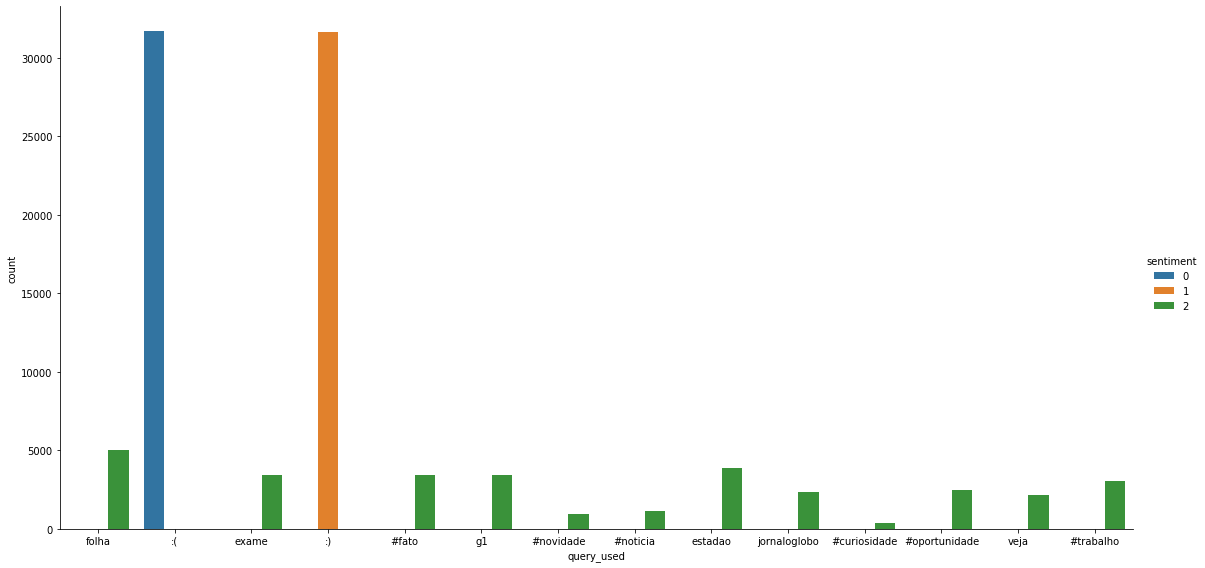

In [12]:
sns.catplot(x='query_used',kind='count', hue='sentiment', data=df, height=8, aspect=16/8)

apenas :) tem sentiment = 1 e :( tem sentiment = 0

In [13]:
df[df.duplicated(['tweet_text'], keep=False)].sort_values('tweet_text')

,id,tweet_text,tweet_date,sentiment,query_used
39378,1049701870124584961,"""Em recuperação judicial, Eternit vê receita c...",Tue Oct 09 16:43:23 +0000 2018,2,#trabalho
74323,1049661470877908992,"""Em recuperação judicial, Eternit vê receita c...",Tue Oct 09 14:02:51 +0000 2018,2,#trabalho
26626,1049314705863598080,"#CulturalSpam serale... #notizie #curiose, #in...",Mon Oct 08 15:04:55 +0000 2018,1,:)
36588,1045363120120745984,"#CulturalSpam serale... #notizie #curiose, #in...",Thu Sep 27 17:22:44 +0000 2018,1,:)
21986,1050748068050677761,#FollowFriday Todos os meus seguidores. :) #ff,Fri Oct 12 14:00:36 +0000 2018,1,:)
...,...,...,...,...,...
15184,1049312016803028992,voltei :),Mon Oct 08 14:54:14 +0000 2018,1,:)
89175,1046657747306127360,vou tentar dormir :(,Mon Oct 01 07:07:07 +0000 2018,0,:(
59232,1049173804612800514,vou tentar dormir :(,Mon Oct 08 05:45:02 +0000 2018,0,:(
7137,1043907817550295043,😱NOVOS FILMES E SÉRIES ESTÃO CHEGANDO NA NETFL...,Sun Sep 23 16:59:53 +0000 2018,2,#noticia


In [14]:
df

,id,tweet_text,tweet_date,sentiment,query_used
0,1049721159292346368,Rio elege maior bancada policial de sua histór...,Tue Oct 09 18:00:01 +0000 2018,2,folha
1,1046251157025423360,fiquei tão triste quando eu vi o preço da câme...,Sun Sep 30 04:11:28 +0000 2018,0,:(
2,1041744620206653440,"Para Theresa May, seu plano para o Brexit é a ...",Mon Sep 17 17:44:06 +0000 2018,2,exame
3,1046937084727107589,caralho eu quero proteger a danielly em um pot...,Tue Oct 02 01:37:06 +0000 2018,0,:(
4,1047326854229778432,@SiCaetano_ viva o caos :),Wed Oct 03 03:25:55 +0000 2018,1,:)
...,...,...,...,...,...
94971,1041831666883321856,Cuba e defensor de direitos humanos se unem co...,Mon Sep 17 23:30:00 +0000 2018,2,jornaloglobo
94972,1032352892194369536,#Oportunidade ➡️ Venha fazer parte da nossa eq...,Wed Aug 22 19:44:44 +0000 2018,2,#oportunidade
94973,1046785538542440448,@96syoo EU SEI 😭😭 é por isso que significa mui...,Mon Oct 01 15:34:55 +0000 2018,0,:(
94974,1045457469110177792,@louistsexhes N te conheço mas posta :D,Thu Sep 27 23:37:38 +0000 2018,1,:)


## Pré-processamento e transformações

### Limpeza e lemmatização

In [15]:
nlp = spacy.load("pt_core_news_lg")
def preprocessamento_texto(text, stopwords):
    
    # Colocando todas as letras do texto em caixa baixa:
    text = text.lower()
    # Excluindo citações com @:
    text = re.sub('@[^\s]+', '', text)
    # Excluindo acentuação das palavras:
    text = unidecode(text)
    # Excluindo html tags, como <strong></strong>:
    text = re.sub('<[^<]+?>','', text)
    #Removendo todos os sorrisos
    text = text.replace(':d','')
    text = text.replace(':(','')
    text = text.replace(':)','')
    text = text.replace(':p','')
    # Excluindo os números:
    text = ''.join(c for c in text if not c.isdigit())
    # Excluindo URL's:
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', text)
    # Excluindo pontuação:
    text = ''.join(c for c in text if c not in punctuation)  
    
    #Tokenizando
    doc = nlp(text)
    #Removendo as stopwords:
    text = [word for word in doc if word.text not in stopwords]
    #Removendo palavras que não tem lemma
    text = [word.lemma_.strip() for word in text]
    #Removendo elementos vazio 
    text = [word for word in text if word != '']
    return text

In [16]:
sw = list(set(stopwords.words('portuguese') + list(STOP_WORDS)))

In [17]:
df["filtered_words"] = df['tweet_text'].apply(lambda x: preprocessamento_texto(x,sw))

#juntamos as palavras novamente em uma só string

df['join_words'] = df['filtered_words'].apply(lambda x: ' '.join(x))

In [18]:
df

,id,tweet_text,tweet_date,sentiment,query_used,filtered_words,join_words
0,1049721159292346368,Rio elege maior bancada policial de sua histór...,Tue Oct 09 18:00:01 +0000 2018,2,folha,"[rir, eleger, bancada, policial, historiar]",rir eleger bancada policial historiar
1,1046251157025423360,fiquei tão triste quando eu vi o preço da câme...,Sun Sep 30 04:11:28 +0000 2018,0,:(,"[ficar, tao, triste, vir, preco, camera]",ficar tao triste vir preco camera
2,1041744620206653440,"Para Theresa May, seu plano para o Brexit é a ...",Mon Sep 17 17:44:06 +0000 2018,2,exame,"[theresa, may, planar, brexit, unica, opcao]",theresa may planar brexit unica opcao
3,1046937084727107589,caralho eu quero proteger a danielly em um pot...,Tue Oct 02 01:37:06 +0000 2018,0,:(,"[caralho, proteger, danielly, pote, tadinhaa]",caralho proteger danielly pote tadinhaa
4,1047326854229778432,@SiCaetano_ viva o caos :),Wed Oct 03 03:25:55 +0000 2018,1,:),"[vivo, caos]",vivo caos
...,...,...,...,...,...,...,...
94971,1041831666883321856,Cuba e defensor de direitos humanos se unem co...,Mon Sep 17 23:30:00 +0000 2018,2,jornaloglobo,"[cubar, defensor, direito, humano, unir, chefe...",cubar defensor direito humano unir chefe oea i...
94972,1032352892194369536,#Oportunidade ➡️ Venha fazer parte da nossa eq...,Wed Aug 22 19:44:44 +0000 2018,2,#oportunidade,"[oportunidade, vir, equipar, vago, aberto, alu...",oportunidade vir equipar vago aberto aluno adm...
94973,1046785538542440448,@96syoo EU SEI 😭😭 é por isso que significa mui...,Mon Oct 01 15:34:55 +0000 2018,0,:(,"[significar, to, feliz, amar, pra, deixar, ban...",significar to feliz amar pra deixar bandeiro f...
94974,1045457469110177792,@louistsexhes N te conheço mas posta :D,Thu Sep 27 23:37:38 +0000 2018,1,:),"[n, conheco, posto]",n conheco posto


In [19]:
dataf = df

### Treino e Teste

In [20]:
X = df['join_words']
y = df['sentiment']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                     y, 
                                                     test_size = 0.3, 
                                                     random_state = 42)

In [22]:
random_seed = 42

list_model = [
{'model_name': 'Logistic Regression',
 'estimator' : LogisticRegression(random_state = random_seed, solver='newton-cg')},
{'model_name': 'Decision Tree',
 'estimator' : DecisionTreeClassifier(random_state = random_seed)},
{'model_name': 'Random Forest',
 'estimator' : RandomForestClassifier(random_state = random_seed)}, 
{'model_name': 'AdaBoost',
 'estimator' : AdaBoostClassifier(random_state = random_seed)}
]

### Convertendo textos

#### Count Vectorizer

In [23]:
cv = CountVectorizer()

In [24]:
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

##### Modelo

In [25]:
response_cv, s1_cv, cm_cv = baseline(X_train_cv, X_test_cv, y_train, y_test, list_model)

In [26]:
s1_cv

precision    recall  f1-score  support
model_name          label                                        
Logistic Regression 0       0.721064  0.723870  0.722464     9510
                    1       0.692316  0.700000  0.696137     9550
                    2       0.944349  0.930033  0.937136     9433
Decision Tree       0       0.610095  0.683807  0.644851     9510
                    1       0.595863  0.573089  0.584254     9550
                    2       0.903457  0.828368  0.864285     9433
Random Forest       0       0.654394  0.743849  0.696260     9510
                    1       0.661135  0.617382  0.638510     9550
                    2       0.939418  0.872893  0.904935     9433
AdaBoost            0       0.663426  0.473607  0.552672     9510
                    1       0.486055  0.739058  0.586432     9550
                    2       0.906307  0.690130  0.783582     9433

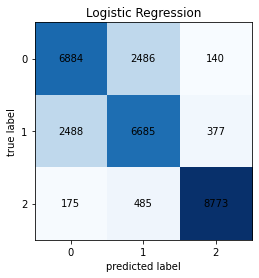

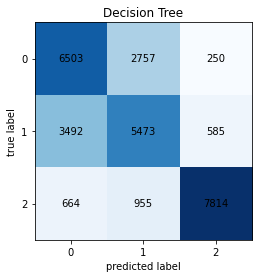

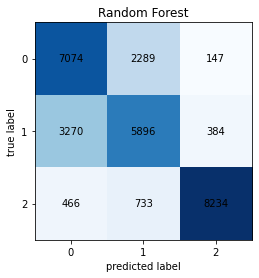

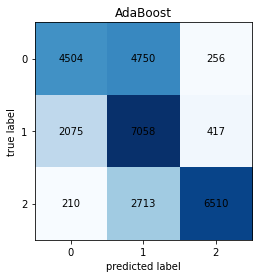

In [27]:
for key, value in cm_cv.items():

    plotting.plot_confusion_matrix(conf_mat=value, fontcolor_threshold=1)
    plt.title(key)
    plt.show()

#### TF-IDF

In [28]:
tfidf = TfidfVectorizer(use_idf=True)

In [29]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

In [30]:
response_tfidf, s1_tfidf, cm_tfidf = baseline(X_train_tfidf, X_test_tfidf, y_train, y_test, list_model)

In [31]:
s1_tfidf

precision    recall  f1-score  support
model_name          label                                        
Logistic Regression 0       0.742737  0.707045  0.724452     9510
                    1       0.696383  0.711623  0.703920     9550
                    2       0.918294  0.942436  0.930208     9433
Decision Tree       0       0.650985  0.653312  0.652147     9510
                    1       0.614780  0.606283  0.610502     9550
                    2       0.891617  0.900880  0.896224     9433
Random Forest       0       0.708421  0.707676  0.708048     9510
                    1       0.680021  0.668272  0.674096     9550
                    2       0.919338  0.936394  0.927787     9433
AdaBoost            0       0.681166  0.474238  0.559172     9510
                    1       0.488166  0.749424  0.591219     9550
                    2       0.907641  0.693841  0.786470     9433

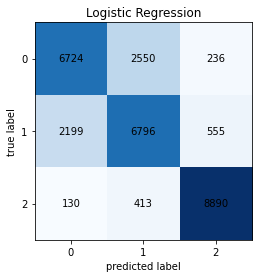

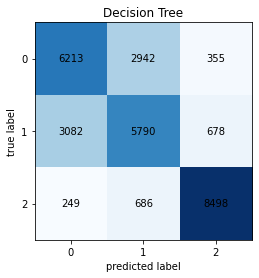

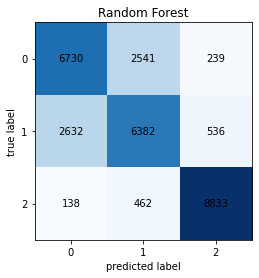

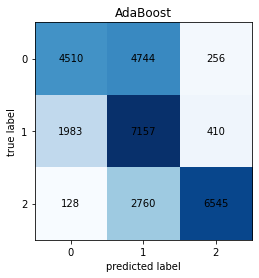

In [32]:
for key, value in cm_tfidf.items():

    plotting.plot_confusion_matrix(conf_mat=value, fontcolor_threshold=1)
    plt.title(key)
    plt.show()

#### Word2vec

In [33]:
df


,id,tweet_text,tweet_date,sentiment,query_used,filtered_words,join_words
0,1049721159292346368,Rio elege maior bancada policial de sua histór...,Tue Oct 09 18:00:01 +0000 2018,2,folha,"[rir, eleger, bancada, policial, historiar]",rir eleger bancada policial historiar
1,1046251157025423360,fiquei tão triste quando eu vi o preço da câme...,Sun Sep 30 04:11:28 +0000 2018,0,:(,"[ficar, tao, triste, vir, preco, camera]",ficar tao triste vir preco camera
2,1041744620206653440,"Para Theresa May, seu plano para o Brexit é a ...",Mon Sep 17 17:44:06 +0000 2018,2,exame,"[theresa, may, planar, brexit, unica, opcao]",theresa may planar brexit unica opcao
3,1046937084727107589,caralho eu quero proteger a danielly em um pot...,Tue Oct 02 01:37:06 +0000 2018,0,:(,"[caralho, proteger, danielly, pote, tadinhaa]",caralho proteger danielly pote tadinhaa
4,1047326854229778432,@SiCaetano_ viva o caos :),Wed Oct 03 03:25:55 +0000 2018,1,:),"[vivo, caos]",vivo caos
...,...,...,...,...,...,...,...
94971,1041831666883321856,Cuba e defensor de direitos humanos se unem co...,Mon Sep 17 23:30:00 +0000 2018,2,jornaloglobo,"[cubar, defensor, direito, humano, unir, chefe...",cubar defensor direito humano unir chefe oea i...
94972,1032352892194369536,#Oportunidade ➡️ Venha fazer parte da nossa eq...,Wed Aug 22 19:44:44 +0000 2018,2,#oportunidade,"[oportunidade, vir, equipar, vago, aberto, alu...",oportunidade vir equipar vago aberto aluno adm...
94973,1046785538542440448,@96syoo EU SEI 😭😭 é por isso que significa mui...,Mon Oct 01 15:34:55 +0000 2018,0,:(,"[significar, to, feliz, amar, pra, deixar, ban...",significar to feliz amar pra deixar bandeiro f...
94974,1045457469110177792,@louistsexhes N te conheço mas posta :D,Thu Sep 27 23:37:38 +0000 2018,1,:),"[n, conheco, posto]",n conheco posto


In [34]:
X_w2v = df['filtered_words']
y_w2v = df['sentiment']

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, 
                                                                     y_w2v, 
                                                                     test_size = 0.3, 
                                                                     random_state = 42)

In [35]:
model = Word2Vec(
    sentences=X_train_w2v,
    vector_size=2,   # Tamanho do vetor de saída
    min_count=1,  # Filtro palavras raras
    workers=2,  # Multicore
    window=5, # Janela de palavras, nesse caso 5 palavras
    sg=1,  # 1 para skip-grams, 0 para o CBOW
)

In [36]:
X_train_w2v_m = []
X_train_w2v_s = []
X_train_w2v_sn = []

for phrase in X_train:
    vecs = []
    for word in phrase:
        if word in model.wv.index_to_key:
            vecs.append(model.wv.get_vector(word))
    if vecs:
        soma = np.sum(vecs, axis=0)
        media = soma / len(vecs)
        soma_normalizada = soma / np.linalg.norm(soma)

        X_train_w2v_m.append(media)
        X_train_w2v_s.append(soma)
        X_train_w2v_sn.append(soma_normalizada)
    else:

        X_train_w2v_m.append(np.zeros(model.vector_size))
        X_train_w2v_s.append(np.zeros(model.vector_size))
        X_train_w2v_sn.append(np.zeros(model.vector_size))

X_train_w2v_m = np.array(X_train_w2v_m)
X_train_w2v_s = np.array(X_train_w2v_s)
X_train_w2v_sn = np.array(X_train_w2v_sn)

In [37]:
np.asarray(vecs).shape

(8, 2)

In [38]:
X_test_w2v_m = []
X_test_w2v_s = []
X_test_w2v_sn = []

for phrase in X_test:
    vecs = []
    for word in phrase:
        if word in model.wv.index_to_key:
            vecs.append(model.wv.get_vector(word))
            
    if vecs:
        soma = np.sum(vecs, axis=0)
        media = soma/len(vecs)
        soma_normalizada = soma / np.linalg.norm(soma)
        
        X_test_w2v_m.append(media)
        X_test_w2v_s.append(soma)
        X_test_w2v_sn.append(soma_normalizada)
        
    else:
        X_test_w2v_m.append(np.zeros(model.vector_size))
        X_test_w2v_s.append(np.zeros(model.vector_size))
        X_test_w2v_sn.append(np.zeros(model.vector_size))
    
    
X_test_w2v_m = np.array(X_test_w2v_m)
X_test_w2v_s = np.array(X_test_w2v_s)
X_test_w2v_sn = np.array(X_test_w2v_sn)

In [39]:
X_test_w2v_m.shape

(28493, 2)

##### usando a media

In [40]:
response_w2v_m, s1_w2v_m, cm_w2v_m = baseline(X_train_w2v_m,
                                              X_test_w2v_m,
                                              y_train_w2v,
                                              y_test_w2v,
                                              list_model)

In [41]:
s1_w2v_m

precision    recall  f1-score  support
model_name          label                                        
Logistic Regression 0       0.360242  0.476761  0.410391     9510
                    1       0.346117  0.225864  0.273349     9550
                    2       0.333850  0.342415  0.338078     9433
Decision Tree       0       0.415679  0.409253  0.412441     9510
                    1       0.389876  0.392775  0.391320     9550
                    2       0.448838  0.452454  0.450639     9433
Random Forest       0       0.425473  0.406414  0.415726     9510
                    1       0.398205  0.376230  0.386906     9550
                    2       0.461583  0.508216  0.483778     9433
AdaBoost            0       0.453580  0.377077  0.411805     9510
                    1       0.426955  0.134346  0.204381     9550
                    2       0.428677  0.799003  0.557986     9433

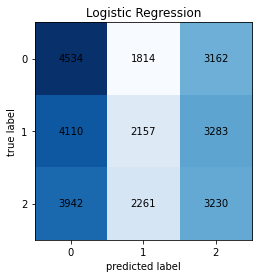

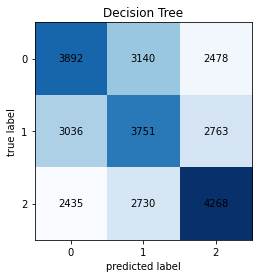

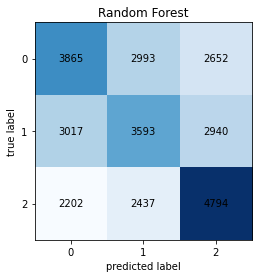

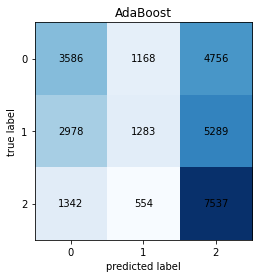

In [42]:
for key, value in cm_w2v_m.items():

    plotting.plot_confusion_matrix(conf_mat=value, fontcolor_threshold=1)
    plt.title(key)
    plt.show()

##### Usando soma

In [43]:
response_w2v_s, s1_w2v_s, cm_w2v_s = baseline(X_train_w2v_s,
                                              X_test_w2v_s,
                                              y_train_w2v,
                                              y_test_w2v,
                                              list_model)

C:\Users\jotap\anaconda3\envs\DataScienceDegree\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\jotap\anaconda3\envs\DataScienceDegree\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


In [44]:
s1_w2v_s

precision    recall  f1-score  support
model_name          label                                        
Logistic Regression 0       0.479760  0.680442  0.562745     9510
                    1       0.260252  0.136230  0.178844     9550
                    2       0.550370  0.583802  0.566593     9433
Decision Tree       0       0.448182  0.448370  0.448276     9510
                    1       0.415578  0.409529  0.412531     9550
                    2       0.555707  0.563659  0.559655     9433
Random Forest       0       0.479964  0.452156  0.465645     9510
                    1       0.432165  0.379581  0.404170     9550
                    2       0.569621  0.673063  0.617037     9433
AdaBoost            0       0.504964  0.620400  0.556761     9510
                    1       0.541667  0.023141  0.044386     9550
                    2       0.523017  0.909361  0.664086     9433

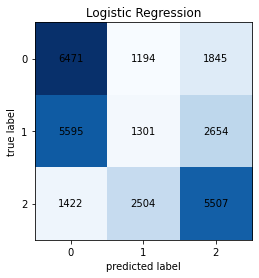

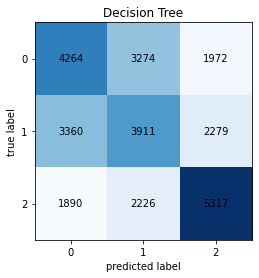

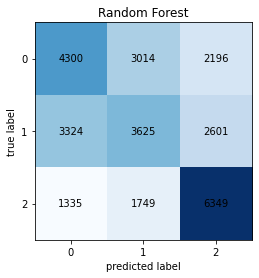

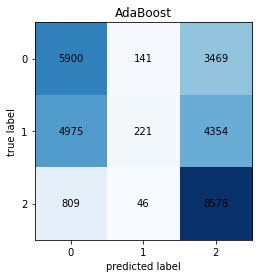

In [45]:
for key, value in cm_w2v_s.items():

    plotting.plot_confusion_matrix(conf_mat=value, fontcolor_threshold=1)
    plt.title(key)
    plt.show()

##### Usando soma normalizada

In [46]:
response_w2v_sn, s1_w2v_sn, cm_w2v_sn = baseline(X_train_w2v_sn,
                                                 X_test_w2v_sn,
                                                 y_train_w2v,
                                                 y_test_w2v,
                                                 list_model)

In [47]:
s1_w2v_sn

precision    recall  f1-score  support
model_name          label                                        
Logistic Regression 0       0.383636  0.408728  0.395785     9510
                    1       0.450218  0.118848  0.188054     9550
                    2       0.388952  0.653133  0.487556     9433
Decision Tree       0       0.402229  0.409884  0.406021     9510
                    1       0.391437  0.390576  0.391006     9550
                    2       0.432977  0.425633  0.429274     9433
Random Forest       0       0.404528  0.398318  0.401399     9510
                    1       0.391842  0.391309  0.391575     9550
                    2       0.433278  0.440581  0.436899     9433
AdaBoost            0       0.461668  0.231125  0.308037     9510
                    1       0.410692  0.172147  0.242603     9550
                    2       0.395104  0.826354  0.534600     9433

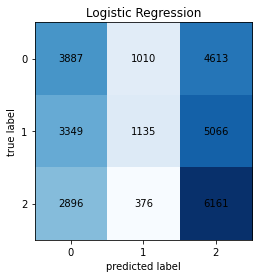

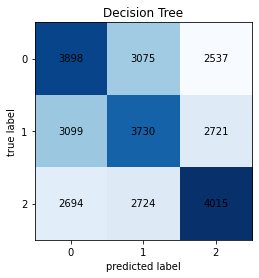

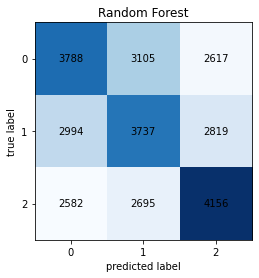

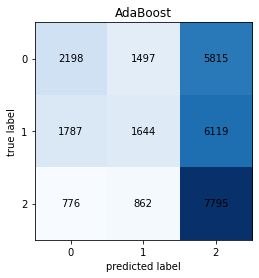

In [48]:
for key, value in cm_w2v_sn.items():

    plotting.plot_confusion_matrix(conf_mat=value, fontcolor_threshold=1)
    plt.title(key)
    plt.show()

## Otimizacao do modelo

### Count Vectorizer - logistic regression

#### cross-validation

In [49]:
model = LogisticRegression(max_iter=200, solver='newton-cg')

In [50]:
response_crossval, s1_crossval, cm_crossval = cross_val(5, model, X_train_cv, y_train, 0.4)
s1_crossval

precision    recall  f1-score  support
Fold   label                                        
Fold 0 0       0.724036  0.719793  0.721908     4436
       1       0.686593  0.706148  0.696234     4424
       2       0.946507  0.925175  0.935719     4437
Fold 1 0       0.720763  0.723687  0.722222     4437
       1       0.695465  0.693264  0.694363     4424
       2       0.937951  0.937106  0.937528     4436
Fold 2 0       0.713397  0.723687  0.718505     4437
       1       0.680942  0.686483  0.683701     4424
       2       0.940729  0.919522  0.930005     4436
Fold 3 0       0.726280  0.719567  0.722908     4436
       1       0.688943  0.708409  0.698540     4424
       2       0.948070  0.930117  0.939008     4436
Fold 4 0       0.722584  0.726330  0.724452     4436
       1       0.694010  0.701854  0.697910     4424
       2       0.947055  0.931470  0.939198     4436

#### Otimização

In [51]:
metric_to_optimze = 'precision'  # accuracy, precision, recall, f1
study_lr_cv = optuna.create_study(direction='maximize')
study_lr_cv.optimize(objective_LR_cv, n_trials=200)

[I 2022-03-24 11:08:53,127] A new study created in memory with name: no-name-486d7802-4273-4dc0-bb43-5dc731b074a6


LogisticRegression(C=3.3943973532830913, max_iter=393.58857429342595,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003278046543498586,
                   warm_start=True)


[I 2022-03-24 11:09:06,834] Trial 0 finished with value: 0.7783453987124325 and parameters: {'tol': 0.003278046543498586, 'C': 3.3943973532830913, 'max_iter': 393.58857429342595, 'warm_start': True}. Best is trial 0 with value: 0.7783453987124325.


LogisticRegression(C=2.9814772414293893, max_iter=199.77597511717798,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00025909076079446466,
                   warm_start=True)


[I 2022-03-24 11:09:19,911] Trial 1 finished with value: 0.7789141574869648 and parameters: {'tol': 0.00025909076079446466, 'C': 2.9814772414293893, 'max_iter': 199.77597511717798, 'warm_start': True}. Best is trial 1 with value: 0.7789141574869648.


LogisticRegression(C=1.2571902861287056, max_iter=389.0433605629889,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0065297457028841484,
                   warm_start=True)


[I 2022-03-24 11:09:27,306] Trial 2 finished with value: 0.7842580095149734 and parameters: {'tol': 0.0065297457028841484, 'C': 1.2571902861287056, 'max_iter': 389.0433605629889, 'warm_start': True}. Best is trial 2 with value: 0.7842580095149734.


LogisticRegression(C=1.1651907987496766, max_iter=381.7321753423638,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00032547308440226096,
                   warm_start=True)


[I 2022-03-24 11:09:36,483] Trial 3 finished with value: 0.7843844271178215 and parameters: {'tol': 0.00032547308440226096, 'C': 1.1651907987496766, 'max_iter': 381.7321753423638, 'warm_start': True}. Best is trial 3 with value: 0.7843844271178215.


LogisticRegression(C=1.9903518974525656, max_iter=321.142619429882,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0024422237300481073)


[I 2022-03-24 11:09:46,367] Trial 4 finished with value: 0.781521365518851 and parameters: {'tol': 0.0024422237300481073, 'C': 1.9903518974525656, 'max_iter': 321.142619429882, 'warm_start': False}. Best is trial 3 with value: 0.7843844271178215.


LogisticRegression(C=3.094782957492364, max_iter=121.60904998098023,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0005432752624601452)


[I 2022-03-24 11:09:59,918] Trial 5 finished with value: 0.7787834020014845 and parameters: {'tol': 0.0005432752624601452, 'C': 3.094782957492364, 'max_iter': 121.60904998098023, 'warm_start': False}. Best is trial 3 with value: 0.7843844271178215.


LogisticRegression(C=1.112037033067126, max_iter=265.2176811645634,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0068290170126804614)


[I 2022-03-24 11:10:06,929] Trial 6 finished with value: 0.7847840967620433 and parameters: {'tol': 0.0068290170126804614, 'C': 1.112037033067126, 'max_iter': 265.2176811645634, 'warm_start': False}. Best is trial 6 with value: 0.7847840967620433.


LogisticRegression(C=1.6390465582164175, max_iter=254.21453815842904,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.004552135035338376)


[I 2022-03-24 11:10:15,691] Trial 7 finished with value: 0.7829477867225604 and parameters: {'tol': 0.004552135035338376, 'C': 1.6390465582164175, 'max_iter': 254.21453815842904, 'warm_start': False}. Best is trial 6 with value: 0.7847840967620433.


LogisticRegression(C=1.8068820492486024, max_iter=340.735500976406,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0050861200878104225,
                   warm_start=True)


[I 2022-03-24 11:10:25,048] Trial 8 finished with value: 0.7821898223448077 and parameters: {'tol': 0.0050861200878104225, 'C': 1.8068820492486024, 'max_iter': 340.735500976406, 'warm_start': True}. Best is trial 6 with value: 0.7847840967620433.


LogisticRegression(C=3.1114582098062327, max_iter=393.0191496157929,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00048150996174016144)


[I 2022-03-24 11:10:38,245] Trial 9 finished with value: 0.7787783149772165 and parameters: {'tol': 0.00048150996174016144, 'C': 3.1114582098062327, 'max_iter': 393.0191496157929, 'warm_start': False}. Best is trial 6 with value: 0.7847840967620433.


LogisticRegression(C=2.498826794437603, max_iter=495.2548698161127,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.001447821265408034)


[I 2022-03-24 11:10:49,948] Trial 10 finished with value: 0.7802553148174276 and parameters: {'tol': 0.001447821265408034, 'C': 2.498826794437603, 'max_iter': 495.2548698161127, 'warm_start': False}. Best is trial 6 with value: 0.7847840967620433.


LogisticRegression(C=1.3036481310610333, max_iter=227.81006460946247,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00010447436292877073,
                   warm_start=True)


[I 2022-03-24 11:10:59,766] Trial 11 finished with value: 0.7840002695146607 and parameters: {'tol': 0.00010447436292877073, 'C': 1.3036481310610333, 'max_iter': 227.81006460946247, 'warm_start': True}. Best is trial 6 with value: 0.7847840967620433.


LogisticRegression(C=1.0327584118655695, max_iter=494.64831551709983,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0010119337506165295,
                   warm_start=True)


[I 2022-03-24 11:11:07,928] Trial 12 finished with value: 0.7848896167765403 and parameters: {'tol': 0.0010119337506165295, 'C': 1.0327584118655695, 'max_iter': 494.64831551709983, 'warm_start': True}. Best is trial 12 with value: 0.7848896167765403.


LogisticRegression(C=1.0359182020668296, max_iter=478.27906162502717,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.009532416756879047)


[I 2022-03-24 11:11:14,845] Trial 13 finished with value: 0.7848876275608075 and parameters: {'tol': 0.009532416756879047, 'C': 1.0359182020668296, 'max_iter': 478.27906162502717, 'warm_start': False}. Best is trial 12 with value: 0.7848896167765403.


LogisticRegression(C=2.357298563820007, max_iter=485.599027526188,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0012815196117773992)


[I 2022-03-24 11:11:26,243] Trial 14 finished with value: 0.780696523835276 and parameters: {'tol': 0.0012815196117773992, 'C': 2.357298563820007, 'max_iter': 485.599027526188, 'warm_start': False}. Best is trial 12 with value: 0.7848896167765403.


LogisticRegression(C=1.5438246372959703, max_iter=451.9561402842462,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00219841907360408,
                   warm_start=True)


[I 2022-03-24 11:11:35,124] Trial 15 finished with value: 0.7832705800174147 and parameters: {'tol': 0.00219841907360408, 'C': 1.5438246372959703, 'max_iter': 451.9561402842462, 'warm_start': True}. Best is trial 12 with value: 0.7848896167765403.


LogisticRegression(C=1.0438109660102601, max_iter=445.76906564474245,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.009263280079921327,
                   warm_start=True)


[I 2022-03-24 11:11:42,030] Trial 16 finished with value: 0.7848325097725655 and parameters: {'tol': 0.009263280079921327, 'C': 1.0438109660102601, 'max_iter': 445.76906564474245, 'warm_start': True}. Best is trial 12 with value: 0.7848896167765403.


LogisticRegression(C=2.0399975018303, max_iter=442.0205016451105,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.000832568648173744)


[I 2022-03-24 11:11:53,268] Trial 17 finished with value: 0.7813662065226405 and parameters: {'tol': 0.000832568648173744, 'C': 2.0399975018303, 'max_iter': 442.0205016451105, 'warm_start': False}. Best is trial 12 with value: 0.7848896167765403.


LogisticRegression(C=2.652263310583538, max_iter=499.30017634794893,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00013352243278860645)


[I 2022-03-24 11:12:06,737] Trial 18 finished with value: 0.7798040961239552 and parameters: {'tol': 0.00013352243278860645, 'C': 2.652263310583538, 'max_iter': 499.30017634794893, 'warm_start': False}. Best is trial 12 with value: 0.7848896167765403.


LogisticRegression(C=1.5215821788404043, max_iter=430.7726842230889,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0008383081181102836,
                   warm_start=True)


[I 2022-03-24 11:12:16,642] Trial 19 finished with value: 0.7833183205464682 and parameters: {'tol': 0.0008383081181102836, 'C': 1.5215821788404043, 'max_iter': 430.7726842230889, 'warm_start': True}. Best is trial 12 with value: 0.7848896167765403.


LogisticRegression(C=1.40549797548041, max_iter=351.5076447636425,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00021401918932792118)


[I 2022-03-24 11:12:26,588] Trial 20 finished with value: 0.7833960788442733 and parameters: {'tol': 0.00021401918932792118, 'C': 1.40549797548041, 'max_iter': 351.5076447636425, 'warm_start': False}. Best is trial 12 with value: 0.7848896167765403.


LogisticRegression(C=1.0271168567015247, max_iter=461.3203964963912,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.009230415640762366,
                   warm_start=True)


[I 2022-03-24 11:12:33,476] Trial 21 finished with value: 0.7848603191694556 and parameters: {'tol': 0.009230415640762366, 'C': 1.0271168567015247, 'max_iter': 461.3203964963912, 'warm_start': True}. Best is trial 12 with value: 0.7848896167765403.


LogisticRegression(C=1.1061199260899899, max_iter=467.3764588252164,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.008120891364776605,
                   warm_start=True)


[I 2022-03-24 11:12:40,518] Trial 22 finished with value: 0.7846841338327282 and parameters: {'tol': 0.008120891364776605, 'C': 1.1061199260899899, 'max_iter': 467.3764588252164, 'warm_start': True}. Best is trial 12 with value: 0.7848896167765403.


LogisticRegression(C=1.004871752481313, max_iter=409.0415067766826,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003902568515926179,
                   warm_start=True)


[I 2022-03-24 11:12:47,572] Trial 23 finished with value: 0.7849678479181211 and parameters: {'tol': 0.003902568515926179, 'C': 1.004871752481313, 'max_iter': 409.0415067766826, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.791982936787588, max_iter=427.08250526794654,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003226896764184513,
                   warm_start=True)


[I 2022-03-24 11:12:57,162] Trial 24 finished with value: 0.7822869520115284 and parameters: {'tol': 0.003226896764184513, 'C': 1.791982936787588, 'max_iter': 427.08250526794654, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.3073237686997148, max_iter=422.0643291443166,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00183602810932045,
                   warm_start=True)


[I 2022-03-24 11:13:05,908] Trial 25 finished with value: 0.7840035306753106 and parameters: {'tol': 0.00183602810932045, 'C': 1.3073237686997148, 'max_iter': 422.0643291443166, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.4481700358258314, max_iter=360.2175728648392,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0046191275390876745,
                   warm_start=True)


[I 2022-03-24 11:13:14,135] Trial 26 finished with value: 0.7835184685375861 and parameters: {'tol': 0.0046191275390876745, 'C': 1.4481700358258314, 'max_iter': 360.2175728648392, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.0241757720970825, max_iter=476.97746749045825,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0032640186969901713,
                   warm_start=True)


[I 2022-03-24 11:13:21,540] Trial 27 finished with value: 0.7848696051457644 and parameters: {'tol': 0.0032640186969901713, 'C': 1.0241757720970825, 'max_iter': 476.97746749045825, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.7613348287145776, max_iter=294.36172524523073,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.005274916884039906)


[I 2022-03-24 11:13:30,482] Trial 28 finished with value: 0.7823244994593714 and parameters: {'tol': 0.005274916884039906, 'C': 1.7613348287145776, 'max_iter': 294.36172524523073, 'warm_start': False}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.311515552587422, max_iter=399.1029550398756,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0027376988511654786,
                   warm_start=True)


[I 2022-03-24 11:13:38,786] Trial 29 finished with value: 0.78394820790943 and parameters: {'tol': 0.0027376988511654786, 'C': 1.311515552587422, 'max_iter': 399.1029550398756, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=3.453467035433277, max_iter=165.7060241154318,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0005443062020899413,
                   warm_start=True)


[I 2022-03-24 11:13:52,324] Trial 30 finished with value: 0.7783155847498278 and parameters: {'tol': 0.0005443062020899413, 'C': 3.453467035433277, 'max_iter': 165.7060241154318, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.0399571681709474, max_iter=472.6610176121173,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.004023021626958092,
                   warm_start=True)


[I 2022-03-24 11:13:59,357] Trial 31 finished with value: 0.7848798995975178 and parameters: {'tol': 0.004023021626958092, 'C': 1.0399571681709474, 'max_iter': 472.6610176121173, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.2581865601438, max_iter=408.585364023407,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0017759987367844314,
                   warm_start=True)


[I 2022-03-24 11:14:07,815] Trial 32 finished with value: 0.7842733476918079 and parameters: {'tol': 0.0017759987367844314, 'C': 1.2581865601438, 'max_iter': 408.585364023407, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.1840869023914342, max_iter=469.3240478438963,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003945396792534867,
                   warm_start=True)


[I 2022-03-24 11:14:15,839] Trial 33 finished with value: 0.7844314939647681 and parameters: {'tol': 0.003945396792534867, 'C': 1.1840869023914342, 'max_iter': 469.3240478438963, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.6410503513429062, max_iter=497.92023655429216,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.006253814150492719,
                   warm_start=True)


[I 2022-03-24 11:14:24,819] Trial 34 finished with value: 0.7829323739541453 and parameters: {'tol': 0.006253814150492719, 'C': 1.6410503513429062, 'max_iter': 497.92023655429216, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.0022483746711222, max_iter=374.82107422970284,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0070085414590037275,
                   warm_start=True)


[I 2022-03-24 11:14:31,573] Trial 35 finished with value: 0.7849470777422998 and parameters: {'tol': 0.0070085414590037275, 'C': 1.0022483746711222, 'max_iter': 374.82107422970284, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.388390719816909, max_iter=370.2014536983829,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.007162149986137509,
                   warm_start=True)


[I 2022-03-24 11:14:39,842] Trial 36 finished with value: 0.7835625577954173 and parameters: {'tol': 0.007162149986137509, 'C': 1.388390719816909, 'max_iter': 370.2014536983829, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.2088564172253182, max_iter=303.3972953699245,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.005828312083571497,
                   warm_start=True)


[I 2022-03-24 11:14:47,094] Trial 37 finished with value: 0.7843144265963605 and parameters: {'tol': 0.005828312083571497, 'C': 1.2088564172253182, 'max_iter': 303.3972953699245, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=2.0577324088107196, max_iter=378.3597606774156,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0075833913217373235)


[I 2022-03-24 11:14:57,052] Trial 38 finished with value: 0.7813374682471863 and parameters: {'tol': 0.0075833913217373235, 'C': 2.0577324088107196, 'max_iter': 378.3597606774156, 'warm_start': False}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.1734354826058888, max_iter=332.8011615194725,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00970801949396429,
                   warm_start=True)


[I 2022-03-24 11:15:04,866] Trial 39 finished with value: 0.7843900690474636 and parameters: {'tol': 0.00970801949396429, 'C': 1.1734354826058888, 'max_iter': 332.8011615194725, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=2.726610594138706, max_iter=419.2605315766929,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00040799979054147775)


[I 2022-03-24 11:15:18,163] Trial 40 finished with value: 0.7795581881861748 and parameters: {'tol': 0.00040799979054147775, 'C': 2.726610594138706, 'max_iter': 419.2605315766929, 'warm_start': False}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.1254621463297547, max_iter=457.38235351739314,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0037161171729166325,
                   warm_start=True)


[I 2022-03-24 11:15:26,272] Trial 41 finished with value: 0.7846852785626091 and parameters: {'tol': 0.0037161171729166325, 'C': 1.1254621463297547, 'max_iter': 457.38235351739314, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.023597584230491, max_iter=478.88994777684627,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0026597788364174885,
                   warm_start=True)


[I 2022-03-24 11:15:33,658] Trial 42 finished with value: 0.7848840747693507 and parameters: {'tol': 0.0026597788364174885, 'C': 1.023597584230491, 'max_iter': 478.88994777684627, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.2126138289873234, max_iter=406.008644663294,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0011274780578720213,
                   warm_start=True)


[I 2022-03-24 11:15:42,396] Trial 43 finished with value: 0.7842770734177267 and parameters: {'tol': 0.0011274780578720213, 'C': 1.2126138289873234, 'max_iter': 406.008644663294, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.3700517064772106, max_iter=390.56716549335533,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002260276691980954,
                   warm_start=True)


[I 2022-03-24 11:15:50,941] Trial 44 finished with value: 0.7835981812579618 and parameters: {'tol': 0.002260276691980954, 'C': 1.3700517064772106, 'max_iter': 390.56716549335533, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.0099595992056243, max_iter=438.61854703074977,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.005080000420126686,
                   warm_start=True)


[I 2022-03-24 11:15:58,179] Trial 45 finished with value: 0.7849630160543505 and parameters: {'tol': 0.005080000420126686, 'C': 1.0099595992056243, 'max_iter': 438.61854703074977, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.5853059471282749, max_iter=439.9650315148007,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.005882808831384594)


[I 2022-03-24 11:16:06,696] Trial 46 finished with value: 0.7832466894885259 and parameters: {'tol': 0.005882808831384594, 'C': 1.5853059471282749, 'max_iter': 439.9650315148007, 'warm_start': False}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.002084713962284, max_iter=106.53430143766883,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.004863219548647665,
                   warm_start=True)


[I 2022-03-24 11:16:13,806] Trial 47 finished with value: 0.7849470777422998 and parameters: {'tol': 0.004863219548647665, 'C': 1.002084713962284, 'max_iter': 106.53430143766883, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=3.3074038157807304, max_iter=157.84388541820138,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.004840509248837607,
                   warm_start=True)


[I 2022-03-24 11:16:25,155] Trial 48 finished with value: 0.7784231179406653 and parameters: {'tol': 0.004840509248837607, 'C': 3.3074038157807304, 'max_iter': 157.84388541820138, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.1452810226180135, max_iter=221.60099021511286,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0015985950610295095,
                   warm_start=True)


[I 2022-03-24 11:16:33,786] Trial 49 finished with value: 0.7845822216500837 and parameters: {'tol': 0.0015985950610295095, 'C': 1.1452810226180135, 'max_iter': 221.60099021511286, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.4669833078958567, max_iter=265.3942005220821,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0002592966345647735,
                   warm_start=True)


[I 2022-03-24 11:16:43,927] Trial 50 finished with value: 0.7834241677632069 and parameters: {'tol': 0.0002592966345647735, 'C': 1.4669833078958567, 'max_iter': 265.3942005220821, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.0027826497295442, max_iter=104.83596621924752,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00769368080469309,
                   warm_start=True)


[I 2022-03-24 11:16:50,954] Trial 51 finished with value: 0.7849470777422998 and parameters: {'tol': 0.00769368080469309, 'C': 1.0027826497295442, 'max_iter': 104.83596621924752, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.2776337186234203, max_iter=142.88997870398157,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0068924358703294965,
                   warm_start=True)


[I 2022-03-24 11:16:58,542] Trial 52 finished with value: 0.7842113669911321 and parameters: {'tol': 0.0068924358703294965, 'C': 1.2776337186234203, 'max_iter': 142.88997870398157, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.006969238238275, max_iter=112.54274241195654,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.004369025276407184,
                   warm_start=True)


[I 2022-03-24 11:17:06,241] Trial 53 finished with value: 0.7849587180917477 and parameters: {'tol': 0.004369025276407184, 'C': 1.006969238238275, 'max_iter': 112.54274241195654, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.122719928196566, max_iter=106.71236677922771,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.005338152051118912,
                   warm_start=True)


[I 2022-03-24 11:17:13,376] Trial 54 finished with value: 0.7847292873436661 and parameters: {'tol': 0.005338152051118912, 'C': 1.122719928196566, 'max_iter': 106.71236677922771, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.0010775895427049, max_iter=127.26620647266404,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.004393897703563241,
                   warm_start=True)


[I 2022-03-24 11:17:20,588] Trial 55 finished with value: 0.7849462080945353 and parameters: {'tol': 0.004393897703563241, 'C': 1.0010775895427049, 'max_iter': 127.26620647266404, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.1124432777596094, max_iter=105.43141818970795,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.008075819214708227,
                   warm_start=True)


[I 2022-03-24 11:17:28,038] Trial 56 finished with value: 0.7847844827686917 and parameters: {'tol': 0.008075819214708227, 'C': 1.1124432777596094, 'max_iter': 105.43141818970795, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.2619505693991444, max_iter=187.2475580930618,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0030661547815538674,
                   warm_start=True)


[I 2022-03-24 11:17:36,083] Trial 57 finished with value: 0.7842624518595898 and parameters: {'tol': 0.0030661547815538674, 'C': 1.2619505693991444, 'max_iter': 187.2475580930618, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=2.159822749991458, max_iter=135.25900645726668,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003585448248306271,
                   warm_start=True)


[I 2022-03-24 11:17:47,076] Trial 58 finished with value: 0.7810755664467641 and parameters: {'tol': 0.003585448248306271, 'C': 2.159822749991458, 'max_iter': 135.25900645726668, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.9188607163846014, max_iter=151.89804439798775,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.006350789872214038,
                   warm_start=True)


[I 2022-03-24 11:17:56,065] Trial 59 finished with value: 0.781781367732713 and parameters: {'tol': 0.006350789872214038, 'C': 1.9188607163846014, 'max_iter': 151.89804439798775, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.3715901759214426, max_iter=124.0003285869994,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.008074241456080296,
                   warm_start=True)


[I 2022-03-24 11:18:04,033] Trial 60 finished with value: 0.783587612582684 and parameters: {'tol': 0.008074241456080296, 'C': 1.3715901759214426, 'max_iter': 124.0003285869994, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.0224262077285666, max_iter=119.87240586874486,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0043909399665408525,
                   warm_start=True)


[I 2022-03-24 11:18:11,590] Trial 61 finished with value: 0.7849023983650762 and parameters: {'tol': 0.0043909399665408525, 'C': 1.0224262077285666, 'max_iter': 119.87240586874486, 'warm_start': True}. Best is trial 23 with value: 0.7849678479181211.


LogisticRegression(C=1.0000277432213343, max_iter=100.59390263582986,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00429619220921027,
                   warm_start=True)


[I 2022-03-24 11:18:18,862] Trial 62 finished with value: 0.7849750984092239 and parameters: {'tol': 0.00429619220921027, 'C': 1.0000277432213343, 'max_iter': 100.59390263582986, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1131949563815002, max_iter=105.75094070804515,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.005801388851176845,
                   warm_start=True)


[I 2022-03-24 11:18:26,184] Trial 63 finished with value: 0.7847844827686917 and parameters: {'tol': 0.005801388851176845, 'C': 1.1131949563815002, 'max_iter': 105.75094070804515, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.221599992178981, max_iter=120.7425115291993,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0029866607089757036,
                   warm_start=True)


[I 2022-03-24 11:18:33,573] Trial 64 finished with value: 0.7842469422296894 and parameters: {'tol': 0.0029866607089757036, 'C': 1.221599992178981, 'max_iter': 120.7425115291993, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0937833853492762, max_iter=171.9495251499254,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0049463606067334034,
                   warm_start=True)


[I 2022-03-24 11:18:40,905] Trial 65 finished with value: 0.7847534286788348 and parameters: {'tol': 0.0049463606067334034, 'C': 1.0937833853492762, 'max_iter': 171.9495251499254, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.3082273883257847, max_iter=100.56949259540305,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.001991045531790135,
                   warm_start=True)


[I 2022-03-24 11:18:49,638] Trial 66 finished with value: 0.7840035306753106 and parameters: {'tol': 0.001991045531790135, 'C': 1.3082273883257847, 'max_iter': 100.56949259540305, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.184564818885733, max_iter=139.14349075298068,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003493412168419352,
                   warm_start=True)


[I 2022-03-24 11:18:57,327] Trial 67 finished with value: 0.7844200433415373 and parameters: {'tol': 0.003493412168419352, 'C': 1.184564818885733, 'max_iter': 139.14349075298068, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0025537419413302, max_iter=149.49976495768638,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0024564118494405634,
                   warm_start=True)


[I 2022-03-24 11:19:04,790] Trial 68 finished with value: 0.7849470777422998 and parameters: {'tol': 0.0024564118494405634, 'C': 1.0025537419413302, 'max_iter': 149.49976495768638, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0828684388705105, max_iter=182.4100827480076,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0025715135752547532,
                   warm_start=True)


[I 2022-03-24 11:19:12,920] Trial 69 finished with value: 0.7846955791461666 and parameters: {'tol': 0.0025715135752547532, 'C': 1.0828684388705105, 'max_iter': 182.4100827480076, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=2.9000167613424344, max_iter=153.02295297645122,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003996442052287703,
                   warm_start=True)


[I 2022-03-24 11:19:23,847] Trial 70 finished with value: 0.7791264918465092 and parameters: {'tol': 0.003996442052287703, 'C': 2.9000167613424344, 'max_iter': 153.02295297645122, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0003518689700548, max_iter=113.59292015736585,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.006941065949751301,
                   warm_start=True)


[I 2022-03-24 11:19:30,714] Trial 71 finished with value: 0.7849750984092239 and parameters: {'tol': 0.006941065949751301, 'C': 1.0003518689700548, 'max_iter': 113.59292015736585, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0791302782444443, max_iter=115.14720590245636,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0054148585346156745,
                   warm_start=True)


[I 2022-03-24 11:19:38,063] Trial 72 finished with value: 0.78465272272144 and parameters: {'tol': 0.0054148585346156745, 'C': 1.0791302782444443, 'max_iter': 115.14720590245636, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1728877395656077, max_iter=139.68795197311977,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00434166444078553,
                   warm_start=True)


[I 2022-03-24 11:19:45,445] Trial 73 finished with value: 0.784405415638079 and parameters: {'tol': 0.00434166444078553, 'C': 1.1728877395656077, 'max_iter': 139.68795197311977, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.3361028910101134, max_iter=130.93310810339432,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.006453198447106417,
                   warm_start=True)


[I 2022-03-24 11:19:53,851] Trial 74 finished with value: 0.7837566009248084 and parameters: {'tol': 0.006453198447106417, 'C': 1.3361028910101134, 'max_iter': 130.93310810339432, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=2.4452540606004245, max_iter=115.88829634218555,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.008217770878101854,
                   warm_start=True)


[I 2022-03-24 11:20:03,899] Trial 75 finished with value: 0.780312743776568 and parameters: {'tol': 0.008217770878101854, 'C': 2.4452540606004245, 'max_iter': 115.88829634218555, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.2489359854876103, max_iter=201.21962139844115,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0029033549751861514,
                   warm_start=True)


[I 2022-03-24 11:20:11,516] Trial 76 finished with value: 0.7842639191671055 and parameters: {'tol': 0.0029033549751861514, 'C': 1.2489359854876103, 'max_iter': 201.21962139844115, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.4702901037237037, max_iter=315.15736995425465,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.008878593903261433,
                   warm_start=True)


[I 2022-03-24 11:20:19,272] Trial 77 finished with value: 0.7834265861775274 and parameters: {'tol': 0.008878593903261433, 'C': 1.4702901037237037, 'max_iter': 315.15736995425465, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0749335377799407, max_iter=414.1647153020259,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.007443488989443145,
                   warm_start=True)


[I 2022-03-24 11:20:26,377] Trial 78 finished with value: 0.7846579828090204 and parameters: {'tol': 0.007443488989443145, 'C': 1.0749335377799407, 'max_iter': 414.1647153020259, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0043991987437046, max_iter=356.0540473106793,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002333545121819195,
                   warm_start=True)


[I 2022-03-24 11:20:34,099] Trial 79 finished with value: 0.7849536144055083 and parameters: {'tol': 0.002333545121819195, 'C': 1.0043991987437046, 'max_iter': 356.0540473106793, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1638115637003736, max_iter=351.2630603081815,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0022953841602288217,
                   warm_start=True)


[I 2022-03-24 11:20:42,295] Trial 80 finished with value: 0.7843963562034277 and parameters: {'tol': 0.0022953841602288217, 'C': 1.1638115637003736, 'max_iter': 351.2630603081815, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0066456713214813, max_iter=377.95280391031514,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0033960180326035997,
                   warm_start=True)


[I 2022-03-24 11:20:49,703] Trial 81 finished with value: 0.7849587180917477 and parameters: {'tol': 0.0033960180326035997, 'C': 1.0066456713214813, 'max_iter': 377.95280391031514, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0809362328754668, max_iter=378.72947456377545,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003572803843080559,
                   warm_start=True)


[I 2022-03-24 11:20:57,470] Trial 82 finished with value: 0.7846631527044365 and parameters: {'tol': 0.003572803843080559, 'C': 1.0809362328754668, 'max_iter': 378.72947456377545, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.216474992684669, max_iter=438.5645544977973,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.004887716958071954,
                   warm_start=True)


[I 2022-03-24 11:21:05,338] Trial 83 finished with value: 0.7842706229582764 and parameters: {'tol': 0.004887716958071954, 'C': 1.216474992684669, 'max_iter': 438.5645544977973, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0671146221600556, max_iter=400.99939485215435,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.007049222026091275,
                   warm_start=True)


[I 2022-03-24 11:21:12,475] Trial 84 finished with value: 0.7847004651067679 and parameters: {'tol': 0.007049222026091275, 'C': 1.0671146221600556, 'max_iter': 400.99939485215435, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1510278849309046, max_iter=342.4663316553308,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0013715585712257819)


[I 2022-03-24 11:21:20,402] Trial 85 finished with value: 0.7845474034312071 and parameters: {'tol': 0.0013715585712257819, 'C': 1.1510278849309046, 'max_iter': 342.4663316553308, 'warm_start': False}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0584207793517613, max_iter=366.63168213585976,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003993341560958808,
                   warm_start=True)


[I 2022-03-24 11:21:27,787] Trial 86 finished with value: 0.7847864353191742 and parameters: {'tol': 0.003993341560958808, 'C': 1.0584207793517613, 'max_iter': 366.63168213585976, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0055927001125875, max_iter=392.5672952480578,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003227393069208278,
                   warm_start=True)


[I 2022-03-24 11:21:34,879] Trial 87 finished with value: 0.784937640637841 and parameters: {'tol': 0.003227393069208278, 'C': 1.0055927001125875, 'max_iter': 392.5672952480578, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.265267715139628, max_iter=271.7220092472846,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0007626742999459398,
                   warm_start=True)


[I 2022-03-24 11:21:43,700] Trial 88 finished with value: 0.7842945633868112 and parameters: {'tol': 0.0007626742999459398, 'C': 1.265267715139628, 'max_iter': 271.7220092472846, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.153142609620613, max_iter=331.48856203242093,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002568647140250979,
                   warm_start=True)


[I 2022-03-24 11:21:51,741] Trial 89 finished with value: 0.784481999301839 and parameters: {'tol': 0.002568647140250979, 'C': 1.153142609620613, 'max_iter': 331.48856203242093, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.4152772698548883, max_iter=360.032510654177,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0052935905089176285,
                   warm_start=True)


[I 2022-03-24 11:21:59,784] Trial 90 finished with value: 0.7833753875654221 and parameters: {'tol': 0.0052935905089176285, 'C': 1.4152772698548883, 'max_iter': 360.032510654177, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0077037638375397, max_iter=113.4393724031221,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.001889473133550664,
                   warm_start=True)


[I 2022-03-24 11:22:07,488] Trial 91 finished with value: 0.7849588477852985 and parameters: {'tol': 0.001889473133550664, 'C': 1.0077037638375397, 'max_iter': 113.4393724031221, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1211176755555323, max_iter=383.83743547606514,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0017377240254180504,
                   warm_start=True)


[I 2022-03-24 11:22:15,535] Trial 92 finished with value: 0.7847304573297649 and parameters: {'tol': 0.0017377240254180504, 'C': 1.1211176755555323, 'max_iter': 383.83743547606514, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0041581437387752, max_iter=113.35977019753055,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002124638998377944,
                   warm_start=True)


[I 2022-03-24 11:22:23,228] Trial 93 finished with value: 0.7849393834341003 and parameters: {'tol': 0.002124638998377944, 'C': 1.0041581437387752, 'max_iter': 113.35977019753055, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0648264288509925, max_iter=433.026508932644,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0015600546628987656,
                   warm_start=True)


[I 2022-03-24 11:22:31,623] Trial 94 finished with value: 0.7847260464868068 and parameters: {'tol': 0.0015600546628987656, 'C': 1.0648264288509925, 'max_iter': 433.026508932644, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.2165222408565133, max_iter=447.53529147550773,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.005878144576021896,
                   warm_start=True)


[I 2022-03-24 11:22:39,253] Trial 95 finished with value: 0.7842706229582764 and parameters: {'tol': 0.005878144576021896, 'C': 1.2165222408565133, 'max_iter': 447.53529147550773, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1380352454137486, max_iter=129.35693079297056,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.004274641088250999,
                   warm_start=True)


[I 2022-03-24 11:22:46,881] Trial 96 finished with value: 0.7846092949707677 and parameters: {'tol': 0.004274641088250999, 'C': 1.1380352454137486, 'max_iter': 129.35693079297056, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.320725709683483, max_iter=414.083883350241,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003646154018410245)


[I 2022-03-24 11:22:55,310] Trial 97 finished with value: 0.783926757008361 and parameters: {'tol': 0.003646154018410245, 'C': 1.320725709683483, 'max_iter': 414.083883350241, 'warm_start': False}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0492705132645384, max_iter=424.67042019881444,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00650035617404908,
                   warm_start=True)


[I 2022-03-24 11:23:02,211] Trial 98 finished with value: 0.784802783323725 and parameters: {'tol': 0.00650035617404908, 'C': 1.0492705132645384, 'max_iter': 424.67042019881444, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.702855047840856, max_iter=373.59965943674996,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0032391981423420453,
                   warm_start=True)


[I 2022-03-24 11:23:11,514] Trial 99 finished with value: 0.7826732367155234 and parameters: {'tol': 0.0032391981423420453, 'C': 1.702855047840856, 'max_iter': 373.59965943674996, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.2056003820160428, max_iter=243.69384751777753,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.004801973435671963,
                   warm_start=True)


[I 2022-03-24 11:23:19,028] Trial 100 finished with value: 0.7843144265963605 and parameters: {'tol': 0.004801973435671963, 'C': 1.2056003820160428, 'max_iter': 243.69384751777753, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0042268685145186, max_iter=146.42674747501852,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0026875596783136357,
                   warm_start=True)


[I 2022-03-24 11:23:26,610] Trial 101 finished with value: 0.7849536144055083 and parameters: {'tol': 0.0026875596783136357, 'C': 1.0042268685145186, 'max_iter': 146.42674747501852, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0499785331412959, max_iter=146.5072285745249,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0029197754155651312,
                   warm_start=True)


[I 2022-03-24 11:23:34,094] Trial 102 finished with value: 0.7847885507687039 and parameters: {'tol': 0.0029197754155651312, 'C': 1.0499785331412959, 'max_iter': 146.5072285745249, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1172481571277955, max_iter=159.79084003361424,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0024522121059372386,
                   warm_start=True)


[I 2022-03-24 11:23:41,967] Trial 103 finished with value: 0.784757949776529 and parameters: {'tol': 0.0024522121059372386, 'C': 1.1172481571277955, 'max_iter': 159.79084003361424, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0075275959958665, max_iter=100.31758361607483,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0019508610518414631,
                   warm_start=True)


[I 2022-03-24 11:23:49,716] Trial 104 finished with value: 0.7849588477852985 and parameters: {'tol': 0.0019508610518414631, 'C': 1.0075275959958665, 'max_iter': 100.31758361607483, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0975171875670986, max_iter=100.21623273674577,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0019049751090153394,
                   warm_start=True)


[I 2022-03-24 11:23:57,734] Trial 105 finished with value: 0.784685645435149 and parameters: {'tol': 0.0019049751090153394, 'C': 1.0975171875670986, 'max_iter': 100.21623273674577, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1688853764169416, max_iter=112.59867895111365,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0011418311942431633,
                   warm_start=True)


[I 2022-03-24 11:24:06,334] Trial 106 finished with value: 0.7843713384460662 and parameters: {'tol': 0.0011418311942431633, 'C': 1.1688853764169416, 'max_iter': 112.59867895111365, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0000706181326244, max_iter=130.67439829657312,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00280637549925988,
                   warm_start=True)


[I 2022-03-24 11:24:13,735] Trial 107 finished with value: 0.7849750984092239 and parameters: {'tol': 0.00280637549925988, 'C': 1.0000706181326244, 'max_iter': 130.67439829657312, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0521540036216503, max_iter=124.66987391609209,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002826409863706432,
                   warm_start=True)


[I 2022-03-24 11:24:21,331] Trial 108 finished with value: 0.7847721017259864 and parameters: {'tol': 0.002826409863706432, 'C': 1.0521540036216503, 'max_iter': 124.66987391609209, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.244959113593643, max_iter=132.242930949813,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002159463165679832,
                   warm_start=True)


[I 2022-03-24 11:24:29,456] Trial 109 finished with value: 0.7842198677863952 and parameters: {'tol': 0.002159463165679832, 'C': 1.244959113593643, 'max_iter': 132.242930949813, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1194210069766395, max_iter=170.51205306200737,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003423598909169423,
                   warm_start=True)


[I 2022-03-24 11:24:37,114] Trial 110 finished with value: 0.7847558631209457 and parameters: {'tol': 0.003423598909169423, 'C': 1.1194210069766395, 'max_iter': 170.51205306200737, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0034801207730066, max_iter=285.0050677302137,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003924275465518969,
                   warm_start=True)


[I 2022-03-24 11:24:44,301] Trial 111 finished with value: 0.7849549254783592 and parameters: {'tol': 0.003924275465518969, 'C': 1.0034801207730066, 'max_iter': 285.0050677302137, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.049419877387707, max_iter=110.71455245105146,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002021093167874087,
                   warm_start=True)


[I 2022-03-24 11:24:52,280] Trial 112 finished with value: 0.784802783323725 and parameters: {'tol': 0.002021093167874087, 'C': 1.049419877387707, 'max_iter': 110.71455245105146, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0001594120678383, max_iter=284.6992353248129,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003900920792827897,
                   warm_start=True)


[I 2022-03-24 11:24:59,296] Trial 113 finished with value: 0.7849750984092239 and parameters: {'tol': 0.003900920792827897, 'C': 1.0001594120678383, 'max_iter': 284.6992353248129, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0921576814042853, max_iter=290.03328712929135,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003794030966645657,
                   warm_start=True)


[I 2022-03-24 11:25:06,871] Trial 114 finished with value: 0.7847425781197932 and parameters: {'tol': 0.003794030966645657, 'C': 1.0921576814042853, 'max_iter': 290.03328712929135, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1788989597568666, max_iter=283.316468192841,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00409076735378707,
                   warm_start=True)


[I 2022-03-24 11:25:14,161] Trial 115 finished with value: 0.7843571101490168 and parameters: {'tol': 0.00409076735378707, 'C': 1.1788989597568666, 'max_iter': 283.316468192841, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=2.284307777982765, max_iter=247.42786754548916,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.004565688402557176)


[I 2022-03-24 11:25:24,693] Trial 116 finished with value: 0.7809317755355384 and parameters: {'tol': 0.004565688402557176, 'C': 2.284307777982765, 'max_iter': 247.42786754548916, 'warm_start': False}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.044559469800309, max_iter=300.939629686275,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003196720367277782,
                   warm_start=True)


[I 2022-03-24 11:25:32,135] Trial 117 finished with value: 0.7848315170906155 and parameters: {'tol': 0.003196720367277782, 'C': 1.044559469800309, 'max_iter': 300.939629686275, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.138486571824561, max_iter=120.41528292753503,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002736125831149339,
                   warm_start=True)


[I 2022-03-24 11:25:39,963] Trial 118 finished with value: 0.7846092949707677 and parameters: {'tol': 0.002736125831149339, 'C': 1.138486571824561, 'max_iter': 120.41528292753503, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.280174099922329, max_iter=217.29705094879478,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.005570618596535216,
                   warm_start=True)


[I 2022-03-24 11:25:48,274] Trial 119 finished with value: 0.7841980624559942 and parameters: {'tol': 0.005570618596535216, 'C': 1.280174099922329, 'max_iter': 217.29705094879478, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=2.6407650999745256, max_iter=308.3876531465183,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003785601581577042,
                   warm_start=True)


[I 2022-03-24 11:25:58,957] Trial 120 finished with value: 0.7797751862459699 and parameters: {'tol': 0.003785601581577042, 'C': 2.6407650999745256, 'max_iter': 308.3876531465183, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0250112467533947, max_iter=134.99218449055851,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0016862760867616864,
                   warm_start=True)


[I 2022-03-24 11:26:06,849] Trial 121 finished with value: 0.7848741255238632 and parameters: {'tol': 0.0016862760867616864, 'C': 1.0250112467533947, 'max_iter': 134.99218449055851, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0066757583281172, max_iter=100.74163860234565,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0022946612256790127,
                   warm_start=True)


[I 2022-03-24 11:26:14,472] Trial 122 finished with value: 0.7849587180917477 and parameters: {'tol': 0.0022946612256790127, 'C': 1.0066757583281172, 'max_iter': 100.74163860234565, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.086469210594373, max_iter=101.20148603084598,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0034282909804088345,
                   warm_start=True)


[I 2022-03-24 11:26:22,326] Trial 123 finished with value: 0.7847601664995599 and parameters: {'tol': 0.0034282909804088345, 'C': 1.086469210594373, 'max_iter': 101.20148603084598, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0069983499026876, max_iter=111.95448113555517,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0030206601079173275,
                   warm_start=True)


[I 2022-03-24 11:26:29,611] Trial 124 finished with value: 0.7849587180917477 and parameters: {'tol': 0.0030206601079173275, 'C': 1.0069983499026876, 'max_iter': 111.95448113555517, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1876063362268743, max_iter=111.40091076955039,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0044899374925274635,
                   warm_start=True)


[I 2022-03-24 11:26:37,238] Trial 125 finished with value: 0.7843903956921687 and parameters: {'tol': 0.0044899374925274635, 'C': 1.1876063362268743, 'max_iter': 111.40091076955039, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0003248590769058, max_iter=120.41792603831581,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0041293992105936785,
                   warm_start=True)


[I 2022-03-24 11:26:44,212] Trial 126 finished with value: 0.7849750984092239 and parameters: {'tol': 0.0041293992105936785, 'C': 1.0003248590769058, 'max_iter': 120.41792603831581, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0962073894293458, max_iter=117.58086168254452,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0014330936253612201,
                   warm_start=True)


[I 2022-03-24 11:26:52,350] Trial 127 finished with value: 0.7847120734484319 and parameters: {'tol': 0.0014330936253612201, 'C': 1.0962073894293458, 'max_iter': 117.58086168254452, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1379669820444234, max_iter=125.80624197507393,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.004253960168652168,
                   warm_start=True)


[I 2022-03-24 11:26:59,879] Trial 128 finished with value: 0.7846092949707677 and parameters: {'tol': 0.004253960168652168, 'C': 1.1379669820444234, 'max_iter': 125.80624197507393, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0612907713344624, max_iter=108.88498700936299,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.005314864618906755,
                   warm_start=True)


[I 2022-03-24 11:27:07,122] Trial 129 finished with value: 0.7847386042851685 and parameters: {'tol': 0.005314864618906755, 'C': 1.0612907713344624, 'max_iter': 108.88498700936299, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.227096998766314, max_iter=458.494708495645,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0029917253645240995,
                   warm_start=True)


[I 2022-03-24 11:27:15,042] Trial 130 finished with value: 0.7842183899319357 and parameters: {'tol': 0.0029917253645240995, 'C': 1.227096998766314, 'max_iter': 458.494708495645, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0049599974582306, max_iter=118.36491076291519,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003216358166324999,
                   warm_start=True)


[I 2022-03-24 11:27:22,139] Trial 131 finished with value: 0.7849678479181211 and parameters: {'tol': 0.003216358166324999, 'C': 1.0049599974582306, 'max_iter': 118.36491076291519, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0541765892346997, max_iter=120.72206438979327,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00016348660134580707,
                   warm_start=True)


[I 2022-03-24 11:27:31,211] Trial 132 finished with value: 0.7847684231175606 and parameters: {'tol': 0.00016348660134580707, 'C': 1.0541765892346997, 'max_iter': 120.72206438979327, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1009579294251775, max_iter=101.08634005684628,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0031583078500069814,
                   warm_start=True)


[I 2022-03-24 11:27:38,902] Trial 133 finished with value: 0.784651784902731 and parameters: {'tol': 0.0031583078500069814, 'C': 1.1009579294251775, 'max_iter': 101.08634005684628, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.003018197964595, max_iter=138.6936897689295,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0023929828626126897,
                   warm_start=True)


[I 2022-03-24 11:27:46,503] Trial 134 finished with value: 0.784965798054389 and parameters: {'tol': 0.0023929828626126897, 'C': 1.003018197964595, 'max_iter': 138.6936897689295, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1421495057801072, max_iter=133.0026799680256,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0023909765435033065,
                   warm_start=True)


[I 2022-03-24 11:27:54,700] Trial 135 finished with value: 0.7845936416441361 and parameters: {'tol': 0.0023909765435033065, 'C': 1.1421495057801072, 'max_iter': 133.0026799680256, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.8955945989536411, max_iter=142.26542458089224,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0034672142402515462,
                   warm_start=True)


[I 2022-03-24 11:28:04,622] Trial 136 finished with value: 0.7818613478666088 and parameters: {'tol': 0.0034672142402515462, 'C': 1.8955945989536411, 'max_iter': 142.26542458089224, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=3.1586950464788544, max_iter=126.49287011344445,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002128065118594957)


[I 2022-03-24 11:28:16,031] Trial 137 finished with value: 0.778563728896849 and parameters: {'tol': 0.002128065118594957, 'C': 3.1586950464788544, 'max_iter': 126.49287011344445, 'warm_start': False}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0538436746058761, max_iter=114.6017424654054,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.004873592374755127,
                   warm_start=True)


[I 2022-03-24 11:28:23,376] Trial 138 finished with value: 0.7847684231175606 and parameters: {'tol': 0.004873592374755127, 'C': 1.0538436746058761, 'max_iter': 114.6017424654054, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0002985166527372, max_iter=137.11853666912924,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0026782410772077697,
                   warm_start=True)


[I 2022-03-24 11:28:30,814] Trial 139 finished with value: 0.7849750984092239 and parameters: {'tol': 0.0026782410772077697, 'C': 1.0002985166527372, 'max_iter': 137.11853666912924, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1743586056664521, max_iter=138.1257948032271,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002593609485370017,
                   warm_start=True)


[I 2022-03-24 11:28:39,023] Trial 140 finished with value: 0.7844050119437288 and parameters: {'tol': 0.002593609485370017, 'C': 1.1743586056664521, 'max_iter': 138.1257948032271, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0073232740343256, max_iter=118.30042430762376,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002897802153924503,
                   warm_start=True)


[I 2022-03-24 11:28:46,494] Trial 141 finished with value: 0.7849588477852985 and parameters: {'tol': 0.002897802153924503, 'C': 1.0073232740343256, 'max_iter': 118.30042430762376, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0021399422218427, max_iter=488.77231659747343,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0018137525184289283,
                   warm_start=True)


[I 2022-03-24 11:28:54,182] Trial 142 finished with value: 0.7849470777422998 and parameters: {'tol': 0.0018137525184289283, 'C': 1.0021399422218427, 'max_iter': 488.77231659747343, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.087836481914095, max_iter=121.52223173526188,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002305593074565625,
                   warm_start=True)


[I 2022-03-24 11:29:01,832] Trial 143 finished with value: 0.7847459578104321 and parameters: {'tol': 0.002305593074565625, 'C': 1.087836481914095, 'max_iter': 121.52223173526188, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0628503362105288, max_iter=161.7835911808614,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0029796034535542267,
                   warm_start=True)


[I 2022-03-24 11:29:09,687] Trial 144 finished with value: 0.7847232727301339 and parameters: {'tol': 0.0029796034535542267, 'C': 1.0628503362105288, 'max_iter': 161.7835911808614, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1244751051184474, max_iter=131.0357175752467,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002707534234109278,
                   warm_start=True)


[I 2022-03-24 11:29:17,582] Trial 145 finished with value: 0.7846996985863672 and parameters: {'tol': 0.002707534234109278, 'C': 1.1244751051184474, 'max_iter': 131.0357175752467, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0000665178110804, max_iter=149.96267749546251,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003677264414949166,
                   warm_start=True)


[I 2022-03-24 11:29:24,880] Trial 146 finished with value: 0.7849750984092239 and parameters: {'tol': 0.003677264414949166, 'C': 1.0000665178110804, 'max_iter': 149.96267749546251, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0813424166654955, max_iter=154.08231079971705,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003790591593173188,
                   warm_start=True)


[I 2022-03-24 11:29:32,397] Trial 147 finished with value: 0.7846631527044365 and parameters: {'tol': 0.003790591593173188, 'C': 1.0813424166654955, 'max_iter': 154.08231079971705, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0595047954908912, max_iter=141.9028754458839,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.004030585670534064,
                   warm_start=True)


[I 2022-03-24 11:29:39,681] Trial 148 finished with value: 0.7847670785035114 and parameters: {'tol': 0.004030585670534064, 'C': 1.0595047954908912, 'max_iter': 141.9028754458839, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1945697554774197, max_iter=149.3954916260435,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0035533904675363577,
                   warm_start=True)


[I 2022-03-24 11:29:47,361] Trial 149 finished with value: 0.784409466299263 and parameters: {'tol': 0.0035533904675363577, 'C': 1.1945697554774197, 'max_iter': 149.3954916260435, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1374112456778904, max_iter=107.93465500072736,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003091680199363654,
                   warm_start=True)


[I 2022-03-24 11:29:55,056] Trial 150 finished with value: 0.7846350024092223 and parameters: {'tol': 0.003091680199363654, 'C': 1.1374112456778904, 'max_iter': 107.93465500072736, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0074236263177911, max_iter=118.41277740478569,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.004405612111987713,
                   warm_start=True)


[I 2022-03-24 11:30:02,102] Trial 151 finished with value: 0.7849588477852985 and parameters: {'tol': 0.004405612111987713, 'C': 1.0074236263177911, 'max_iter': 118.41277740478569, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0505560858797784, max_iter=126.07482815250356,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0045996016931852506,
                   warm_start=True)


[I 2022-03-24 11:30:09,410] Trial 152 finished with value: 0.7847885507687039 and parameters: {'tol': 0.0045996016931852506, 'C': 1.0505560858797784, 'max_iter': 126.07482815250356, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0022326776173323, max_iter=135.45854173507817,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0033020164472253345,
                   warm_start=True)


[I 2022-03-24 11:30:16,728] Trial 153 finished with value: 0.7849470777422998 and parameters: {'tol': 0.0033020164472253345, 'C': 1.0022326776173323, 'max_iter': 135.45854173507817, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1002127281464578, max_iter=119.37291196625327,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002423963634432664,
                   warm_start=True)


[I 2022-03-24 11:30:24,432] Trial 154 finished with value: 0.7846671433903747 and parameters: {'tol': 0.002423963634432664, 'C': 1.1002127281464578, 'max_iter': 119.37291196625327, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0012436930091353, max_iter=115.8946346136747,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0042894818907103435,
                   warm_start=True)


[I 2022-03-24 11:30:31,519] Trial 155 finished with value: 0.7849315356980406 and parameters: {'tol': 0.0042894818907103435, 'C': 1.0012436930091353, 'max_iter': 115.8946346136747, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0503728253190079, max_iter=125.73852227151522,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0028262519244069313,
                   warm_start=True)


[I 2022-03-24 11:30:39,088] Trial 156 finished with value: 0.7847885507687039 and parameters: {'tol': 0.0028262519244069313, 'C': 1.0503728253190079, 'max_iter': 125.73852227151522, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1177529709813159, max_iter=105.55558691795565,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0021238935989286137,
                   warm_start=True)


[I 2022-03-24 11:30:47,216] Trial 157 finished with value: 0.7847723633007659 and parameters: {'tol': 0.0021238935989286137, 'C': 1.1177529709813159, 'max_iter': 105.55558691795565, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0007188674088963, max_iter=101.4505692481737,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0020133575824656798,
                   warm_start=True)


[I 2022-03-24 11:30:54,431] Trial 158 finished with value: 0.7849462080945353 and parameters: {'tol': 0.0020133575824656798, 'C': 1.0007188674088963, 'max_iter': 101.4505692481737, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1588236028216696, max_iter=142.58393354730097,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003741177271580384,
                   warm_start=True)


[I 2022-03-24 11:31:01,964] Trial 159 finished with value: 0.7844108094056709 and parameters: {'tol': 0.003741177271580384, 'C': 1.1588236028216696, 'max_iter': 142.58393354730097, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0507985696756816, max_iter=135.09101724790213,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.005986939370376192)


[I 2022-03-24 11:31:08,913] Trial 160 finished with value: 0.7847885507687039 and parameters: {'tol': 0.005986939370376192, 'C': 1.0507985696756816, 'max_iter': 135.09101724790213, 'warm_start': False}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0433352789801726, max_iter=120.46879115751629,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003316697926272684,
                   warm_start=True)


[I 2022-03-24 11:31:15,986] Trial 161 finished with value: 0.7848325097725655 and parameters: {'tol': 0.003316697926272684, 'C': 1.0433352789801726, 'max_iter': 120.46879115751629, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.094567611163947, max_iter=109.29411636736017,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0028280556363997145,
                   warm_start=True)


[I 2022-03-24 11:31:23,561] Trial 162 finished with value: 0.7847093372536196 and parameters: {'tol': 0.0028280556363997145, 'C': 1.094567611163947, 'max_iter': 109.29411636736017, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.00370354536908, max_iter=112.68309115839804,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.005026223109981468,
                   warm_start=True)


[I 2022-03-24 11:31:30,650] Trial 163 finished with value: 0.7849549254783592 and parameters: {'tol': 0.005026223109981468, 'C': 1.00370354536908, 'max_iter': 112.68309115839804, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0967400547784123, max_iter=408.95897984108376,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.004152427303668143,
                   warm_start=True)


[I 2022-03-24 11:31:38,126] Trial 164 finished with value: 0.7847120734484319 and parameters: {'tol': 0.004152427303668143, 'C': 1.0967400547784123, 'max_iter': 408.95897984108376, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0441417888022733, max_iter=127.93073184574291,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0046206598016345635,
                   warm_start=True)


[I 2022-03-24 11:31:45,743] Trial 165 finished with value: 0.7848469238730459 and parameters: {'tol': 0.0046206598016345635, 'C': 1.0441417888022733, 'max_iter': 127.93073184574291, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1452156728613647, max_iter=105.77851699117424,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0016040619436482875,
                   warm_start=True)


[I 2022-03-24 11:31:53,939] Trial 166 finished with value: 0.7845822216500837 and parameters: {'tol': 0.0016040619436482875, 'C': 1.1452156728613647, 'max_iter': 105.77851699117424, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0039202357918398, max_iter=432.4620692978093,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003689879535203207,
                   warm_start=True)


[I 2022-03-24 11:32:01,304] Trial 167 finished with value: 0.7849549254783592 and parameters: {'tol': 0.003689879535203207, 'C': 1.0039202357918398, 'max_iter': 432.4620692978093, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.072292896184406, max_iter=116.07060342949313,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002574881045496388,
                   warm_start=True)


[I 2022-03-24 11:32:08,976] Trial 168 finished with value: 0.7846784598855918 and parameters: {'tol': 0.002574881045496388, 'C': 1.072292896184406, 'max_iter': 116.07060342949313, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.2196057574084314, max_iter=130.38013111233317,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0007197748078680924,
                   warm_start=True)


[I 2022-03-24 11:32:17,966] Trial 169 finished with value: 0.784250447440942 and parameters: {'tol': 0.0007197748078680924, 'C': 1.2196057574084314, 'max_iter': 130.38013111233317, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1168112109949984, max_iter=149.83836203839596,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.005229193548198475,
                   warm_start=True)


[I 2022-03-24 11:32:25,383] Trial 170 finished with value: 0.784757949776529 and parameters: {'tol': 0.005229193548198475, 'C': 1.1168112109949984, 'max_iter': 149.83836203839596, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0364005943438712, max_iter=112.80862882540042,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0030304243856962253,
                   warm_start=True)


[I 2022-03-24 11:32:32,886] Trial 171 finished with value: 0.7848876275608075 and parameters: {'tol': 0.0030304243856962253, 'C': 1.0364005943438712, 'max_iter': 112.80862882540042, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.001186760304246, max_iter=102.2468290763992,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.004043577039312985,
                   warm_start=True)


[I 2022-03-24 11:32:40,052] Trial 172 finished with value: 0.7849462080945353 and parameters: {'tol': 0.004043577039312985, 'C': 1.001186760304246, 'max_iter': 102.2468290763992, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0546417559105403, max_iter=118.05624788131044,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0024629364767965924,
                   warm_start=True)


[I 2022-03-24 11:32:47,552] Trial 173 finished with value: 0.7847870741158568 and parameters: {'tol': 0.0024629364767965924, 'C': 1.0546417559105403, 'max_iter': 118.05624788131044, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.092151877645688, max_iter=449.80313798985816,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0034274697379285094,
                   warm_start=True)


[I 2022-03-24 11:32:55,073] Trial 174 finished with value: 0.7847425781197932 and parameters: {'tol': 0.0034274697379285094, 'C': 1.092151877645688, 'max_iter': 449.80313798985816, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0410870606101887, max_iter=110.47784805376749,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0022618527954550538,
                   warm_start=True)


[I 2022-03-24 11:33:03,197] Trial 175 finished with value: 0.7848336424951728 and parameters: {'tol': 0.0022618527954550538, 'C': 1.0410870606101887, 'max_iter': 110.47784805376749, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0002131311225362, max_iter=101.15677417161241,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003153523184219974,
                   warm_start=True)


[I 2022-03-24 11:33:10,585] Trial 176 finished with value: 0.7849750984092239 and parameters: {'tol': 0.003153523184219974, 'C': 1.0002131311225362, 'max_iter': 101.15677417161241, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.125349509308265, max_iter=125.57677578623422,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003124507919230341,
                   warm_start=True)


[I 2022-03-24 11:33:18,294] Trial 177 finished with value: 0.7846852785626091 and parameters: {'tol': 0.003124507919230341, 'C': 1.125349509308265, 'max_iter': 125.57677578623422, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0453543107014798, max_iter=119.18224132250486,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0018687800687551095,
                   warm_start=True)


[I 2022-03-24 11:33:26,153] Trial 178 finished with value: 0.7848359767305009 and parameters: {'tol': 0.0018687800687551095, 'C': 1.0453543107014798, 'max_iter': 119.18224132250486, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1677211580337652, max_iter=100.56205412520684,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.004312461274414693,
                   warm_start=True)


[I 2022-03-24 11:33:33,839] Trial 179 finished with value: 0.7843569158920581 and parameters: {'tol': 0.004312461274414693, 'C': 1.1677211580337652, 'max_iter': 100.56205412520684, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0952372385992708, max_iter=326.0970127493466,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003729841547114804,
                   warm_start=True)


[I 2022-03-24 11:33:41,644] Trial 180 finished with value: 0.7847082636543031 and parameters: {'tol': 0.003729841547114804, 'C': 1.0952372385992708, 'max_iter': 326.0970127493466, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0070068698121841, max_iter=110.38242748553598,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0032902769308835525,
                   warm_start=True)


[I 2022-03-24 11:33:49,101] Trial 181 finished with value: 0.7849587180917477 and parameters: {'tol': 0.0032902769308835525, 'C': 1.0070068698121841, 'max_iter': 110.38242748553598, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0108618724890497, max_iter=100.461589560319,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002698389989549661,
                   warm_start=True)


[I 2022-03-24 11:33:56,524] Trial 182 finished with value: 0.7849630160543505 and parameters: {'tol': 0.002698389989549661, 'C': 1.0108618724890497, 'max_iter': 100.461589560319, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.00228350993937, max_iter=200.37346061315546,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0026826689515220474,
                   warm_start=True)


[I 2022-03-24 11:34:03,822] Trial 183 finished with value: 0.7849470777422998 and parameters: {'tol': 0.0026826689515220474, 'C': 1.00228350993937, 'max_iter': 200.37346061315546, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0717206435805062, max_iter=100.14661552424494,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0022564333398716004,
                   warm_start=True)


[I 2022-03-24 11:34:11,525] Trial 184 finished with value: 0.7846784598855918 and parameters: {'tol': 0.0022564333398716004, 'C': 1.0717206435805062, 'max_iter': 100.14661552424494, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0008358999233782, max_iter=109.89443879890452,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003408927405161608,
                   warm_start=True)


[I 2022-03-24 11:34:18,965] Trial 185 finished with value: 0.7849462080945353 and parameters: {'tol': 0.003408927405161608, 'C': 1.0008358999233782, 'max_iter': 109.89443879890452, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0669451484244397, max_iter=136.65350519728779,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002789482200943612,
                   warm_start=True)


[I 2022-03-24 11:34:26,464] Trial 186 finished with value: 0.7847158635387687 and parameters: {'tol': 0.002789482200943612, 'C': 1.0669451484244397, 'max_iter': 136.65350519728779, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1227932911678928, max_iter=120.1121149219834,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.004695228138345327,
                   warm_start=True)


[I 2022-03-24 11:34:33,822] Trial 187 finished with value: 0.7847305436826473 and parameters: {'tol': 0.004695228138345327, 'C': 1.1227932911678928, 'max_iter': 120.1121149219834, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0522395646100111, max_iter=185.6470141358865,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002970381793046541,
                   warm_start=True)


[I 2022-03-24 11:34:41,530] Trial 188 finished with value: 0.7847721017259864 and parameters: {'tol': 0.002970381793046541, 'C': 1.0522395646100111, 'max_iter': 185.6470141358865, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.001259852922566, max_iter=469.1472182023392,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0036323821120291117)


[I 2022-03-24 11:34:48,757] Trial 189 finished with value: 0.7849462080945353 and parameters: {'tol': 0.0036323821120291117, 'C': 1.001259852922566, 'max_iter': 469.1472182023392, 'warm_start': False}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1594924891191962, max_iter=110.64726758126277,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0025602269902314455,
                   warm_start=True)


[I 2022-03-24 11:34:56,309] Trial 190 finished with value: 0.7843963154105846 and parameters: {'tol': 0.0025602269902314455, 'C': 1.1594924891191962, 'max_iter': 110.64726758126277, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0416822571816795, max_iter=398.434687891254,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0030576672617163305,
                   warm_start=True)


[I 2022-03-24 11:35:03,585] Trial 191 finished with value: 0.7848325097725655 and parameters: {'tol': 0.0030576672617163305, 'C': 1.0416822571816795, 'max_iter': 398.434687891254, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=2.155461420390711, max_iter=108.58434992052402,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003356514515980231,
                   warm_start=True)


[I 2022-03-24 11:35:13,541] Trial 192 finished with value: 0.7810312649590865 and parameters: {'tol': 0.003356514515980231, 'C': 2.155461420390711, 'max_iter': 108.58434992052402, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0850692252104053, max_iter=232.02036631400023,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.004009432721548679,
                   warm_start=True)


[I 2022-03-24 11:35:20,854] Trial 193 finished with value: 0.7847599095637661 and parameters: {'tol': 0.004009432721548679, 'C': 1.0850692252104053, 'max_iter': 232.02036631400023, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0411655626154, max_iter=100.29386787917635,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0027833783686561334,
                   warm_start=True)


[I 2022-03-24 11:35:28,562] Trial 194 finished with value: 0.7848336424951728 and parameters: {'tol': 0.0027833783686561334, 'C': 1.0411655626154, 'max_iter': 100.29386787917635, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0037945914202782, max_iter=125.46175932823712,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0019397107769447528,
                   warm_start=True)


[I 2022-03-24 11:35:35,983] Trial 195 finished with value: 0.7849549254783592 and parameters: {'tol': 0.0019397107769447528, 'C': 1.0037945914202782, 'max_iter': 125.46175932823712, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0974461814748513, max_iter=115.85908772419131,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003915527438894595,
                   warm_start=True)


[I 2022-03-24 11:35:43,561] Trial 196 finished with value: 0.784685645435149 and parameters: {'tol': 0.003915527438894595, 'C': 1.0974461814748513, 'max_iter': 115.85908772419131, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0560750807165735, max_iter=122.56375002812544,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0023817260670450035,
                   warm_start=True)


[I 2022-03-24 11:35:51,094] Trial 197 finished with value: 0.7848017383421728 and parameters: {'tol': 0.0023817260670450035, 'C': 1.0560750807165735, 'max_iter': 122.56375002812544, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.0065823941819079, max_iter=105.30188211806548,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003247525176201643,
                   warm_start=True)


[I 2022-03-24 11:35:58,520] Trial 198 finished with value: 0.7849587180917477 and parameters: {'tol': 0.003247525176201643, 'C': 1.0065823941819079, 'max_iter': 105.30188211806548, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


LogisticRegression(C=1.1096027428814232, max_iter=131.65142658263767,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.004509060594038748,
                   warm_start=True)


[I 2022-03-24 11:36:06,209] Trial 199 finished with value: 0.7847450066958818 and parameters: {'tol': 0.004509060594038748, 'C': 1.1096027428814232, 'max_iter': 131.65142658263767, 'warm_start': True}. Best is trial 62 with value: 0.7849750984092239.


In [52]:
model = LogisticRegression(**study_lr_cv.best_params,
                           random_state=42,
                           n_jobs=-1,
                           solver='newton-cg',
                           multi_class='multinomial')
model.fit(X_train_cv, y_train)
y_pred_cv_best = model.predict(X_test_cv)

print(metrics.classification_report(y_test, y_pred_cv_best))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      9510
           1       0.69      0.70      0.70      9550
           2       0.94      0.93      0.94      9433

    accuracy                           0.78     28493
   macro avg       0.79      0.78      0.79     28493
weighted avg       0.79      0.78      0.78     28493



In [53]:
study_lr_cv.best_params

{'tol': 0.00429619220921027,
 'C': 1.0000277432213343,
 'max_iter': 100.59390263582986,
 'warm_start': True}

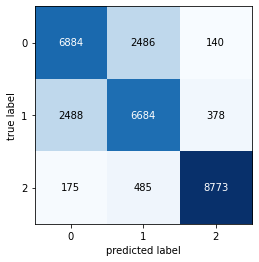

In [54]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_cv_best)

plot_confusion_matrix(conf_mat=cm)
plt.show()

### TF IDF - logistic regression

#### cross-validation

In [55]:
response_crossval, s1_crossval, cm_crossval = cross_val(5, model, X_train_tfidf, y_train, 0.4)
s1_crossval

precision    recall  f1-score  support
Fold   label                                        
Fold 0 0       0.751451  0.700631  0.725152     4436
       1       0.691469  0.731013  0.710691     4424
       2       0.925290  0.935091  0.930165     4437
Fold 1 0       0.750239  0.706108  0.727505     4437
       1       0.698213  0.715416  0.706710     4424
       2       0.917611  0.949053  0.933067     4436
Fold 2 0       0.741576  0.704305  0.722460     4437
       1       0.686995  0.710443  0.698522     4424
       2       0.921029  0.935978  0.928444     4436
Fold 3 0       0.750426  0.694770  0.721526     4436
       1       0.687127  0.728752  0.707328     4424
       2       0.928397  0.941163  0.934736     4436
Fold 4 0       0.746055  0.703336  0.724066     4436
       1       0.694989  0.721067  0.707788     4424
       2       0.926614  0.944995  0.935714     4436

#### Otimização

In [56]:
metric_to_optimze = 'precision'  # accuracy, precision, recall, f1
study_lr_tfidf = optuna.create_study(direction='maximize')
study_lr_tfidf.optimize(objective_LR_tfidf, n_trials=200)

[I 2022-03-24 11:36:21,850] A new study created in memory with name: no-name-2c00c8d4-f1e7-4539-b3d0-a397dc7695f3


LogisticRegression(C=2.9005077453691523, max_iter=300.7438862373682,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0001481041618426176)


[I 2022-03-24 11:36:27,274] Trial 0 finished with value: 0.7854776773413401 and parameters: {'tol': 0.0001481041618426176, 'C': 2.9005077453691523, 'max_iter': 300.7438862373682, 'warm_start': False}. Best is trial 0 with value: 0.7854776773413401.


LogisticRegression(C=1.433393675120575, max_iter=132.8102619171769,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00027676423566542845)


[I 2022-03-24 11:36:31,795] Trial 1 finished with value: 0.7876711883643507 and parameters: {'tol': 0.00027676423566542845, 'C': 1.433393675120575, 'max_iter': 132.8102619171769, 'warm_start': False}. Best is trial 1 with value: 0.7876711883643507.


LogisticRegression(C=2.3430717427458183, max_iter=250.6382631638692,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.000223835122304003)


[I 2022-03-24 11:36:36,999] Trial 2 finished with value: 0.7866961754741416 and parameters: {'tol': 0.000223835122304003, 'C': 2.3430717427458183, 'max_iter': 250.6382631638692, 'warm_start': False}. Best is trial 1 with value: 0.7876711883643507.


LogisticRegression(C=1.4503089191597436, max_iter=347.0237805391935,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00101628606572264)


[I 2022-03-24 11:36:41,041] Trial 3 finished with value: 0.7877779309654016 and parameters: {'tol': 0.00101628606572264, 'C': 1.4503089191597436, 'max_iter': 347.0237805391935, 'warm_start': False}. Best is trial 3 with value: 0.7877779309654016.


LogisticRegression(C=1.7636221473728588, max_iter=217.532322253027,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0004071233723319944)


[I 2022-03-24 11:36:45,363] Trial 4 finished with value: 0.7873921409160948 and parameters: {'tol': 0.0004071233723319944, 'C': 1.7636221473728588, 'max_iter': 217.532322253027, 'warm_start': False}. Best is trial 3 with value: 0.7877779309654016.


LogisticRegression(C=1.0652322334847248, max_iter=152.2703996485199,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.008042546945758752,
                   warm_start=True)


[I 2022-03-24 11:36:48,611] Trial 5 finished with value: 0.787593949182866 and parameters: {'tol': 0.008042546945758752, 'C': 1.0652322334847248, 'max_iter': 152.2703996485199, 'warm_start': True}. Best is trial 3 with value: 0.7877779309654016.


LogisticRegression(C=1.5561442952644724, max_iter=250.68025038650325,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0009469009812596762)


[I 2022-03-24 11:36:52,637] Trial 6 finished with value: 0.7877191560192397 and parameters: {'tol': 0.0009469009812596762, 'C': 1.5561442952644724, 'max_iter': 250.68025038650325, 'warm_start': False}. Best is trial 3 with value: 0.7877779309654016.


LogisticRegression(C=2.0386069950212398, max_iter=414.520582135965,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.005497227931605011,
                   warm_start=True)


[I 2022-03-24 11:36:56,629] Trial 7 finished with value: 0.7870704240148113 and parameters: {'tol': 0.005497227931605011, 'C': 2.0386069950212398, 'max_iter': 414.520582135965, 'warm_start': True}. Best is trial 3 with value: 0.7877779309654016.


LogisticRegression(C=2.8103553602239493, max_iter=159.15149581891149,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0007367860752218393,
                   warm_start=True)


[I 2022-03-24 11:37:01,870] Trial 8 finished with value: 0.7856665291466455 and parameters: {'tol': 0.0007367860752218393, 'C': 2.8103553602239493, 'max_iter': 159.15149581891149, 'warm_start': True}. Best is trial 3 with value: 0.7877779309654016.


LogisticRegression(C=3.1786399150472606, max_iter=359.1980537255984,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0001334666136952208,
                   warm_start=True)


[I 2022-03-24 11:37:07,520] Trial 9 finished with value: 0.7852252667129844 and parameters: {'tol': 0.0001334666136952208, 'C': 3.1786399150472606, 'max_iter': 359.1980537255984, 'warm_start': True}. Best is trial 3 with value: 0.7877779309654016.


LogisticRegression(C=1.1142543061132093, max_iter=493.98863096090713,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002559314745984646)


[I 2022-03-24 11:37:11,128] Trial 10 finished with value: 0.7878316353331233 and parameters: {'tol': 0.002559314745984646, 'C': 1.1142543061132093, 'max_iter': 493.98863096090713, 'warm_start': False}. Best is trial 10 with value: 0.7878316353331233.


LogisticRegression(C=1.006768784456824, max_iter=479.97199286159935,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003826317407963089)


[I 2022-03-24 11:37:14,685] Trial 11 finished with value: 0.7878907352191649 and parameters: {'tol': 0.003826317407963089, 'C': 1.006768784456824, 'max_iter': 479.97199286159935, 'warm_start': False}. Best is trial 11 with value: 0.7878907352191649.


LogisticRegression(C=1.0638955984148497, max_iter=490.76682742579254,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0029533152730060104)


[I 2022-03-24 11:37:18,225] Trial 12 finished with value: 0.7875662907132059 and parameters: {'tol': 0.0029533152730060104, 'C': 1.0638955984148497, 'max_iter': 490.76682742579254, 'warm_start': False}. Best is trial 11 with value: 0.7878907352191649.


LogisticRegression(C=1.0172358271742497, max_iter=499.6170809825261,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002364267211230059)


[I 2022-03-24 11:37:22,000] Trial 13 finished with value: 0.7878273073156937 and parameters: {'tol': 0.002364267211230059, 'C': 1.0172358271742497, 'max_iter': 499.6170809825261, 'warm_start': False}. Best is trial 11 with value: 0.7878907352191649.


LogisticRegression(C=2.40275430927863, max_iter=431.522537646615,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0025297074474843907)


[I 2022-03-24 11:37:26,328] Trial 14 finished with value: 0.7864518852648175 and parameters: {'tol': 0.0025297074474843907, 'C': 2.40275430927863, 'max_iter': 431.522537646615, 'warm_start': False}. Best is trial 11 with value: 0.7878907352191649.


LogisticRegression(C=1.9182653785059705, max_iter=432.2708342526352,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00439495372072836)


[I 2022-03-24 11:37:30,256] Trial 15 finished with value: 0.7873096764237084 and parameters: {'tol': 0.00439495372072836, 'C': 1.9182653785059705, 'max_iter': 432.2708342526352, 'warm_start': False}. Best is trial 11 with value: 0.7878907352191649.


LogisticRegression(C=1.3200823436187408, max_iter=460.44182597941904,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0016952445851276692)


[I 2022-03-24 11:37:34,179] Trial 16 finished with value: 0.7878371124341572 and parameters: {'tol': 0.0016952445851276692, 'C': 1.3200823436187408, 'max_iter': 460.44182597941904, 'warm_start': False}. Best is trial 11 with value: 0.7878907352191649.


LogisticRegression(C=1.3237885127252873, max_iter=382.25905739029076,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0013452158966844165)


[I 2022-03-24 11:37:38,499] Trial 17 finished with value: 0.7878182404588087 and parameters: {'tol': 0.0013452158966844165, 'C': 1.3237885127252873, 'max_iter': 382.25905739029076, 'warm_start': False}. Best is trial 11 with value: 0.7878907352191649.


LogisticRegression(C=1.6932806833283904, max_iter=455.03763444349704,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.008866939747138612,
                   warm_start=True)


[I 2022-03-24 11:37:42,004] Trial 18 finished with value: 0.7873591665254827 and parameters: {'tol': 0.008866939747138612, 'C': 1.6932806833283904, 'max_iter': 455.03763444349704, 'warm_start': True}. Best is trial 11 with value: 0.7878907352191649.


LogisticRegression(C=2.094405061070491, max_iter=309.5193773812387,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0014814601831046328)


[I 2022-03-24 11:37:46,280] Trial 19 finished with value: 0.7869462921376538 and parameters: {'tol': 0.0014814601831046328, 'C': 2.094405061070491, 'max_iter': 309.5193773812387, 'warm_start': False}. Best is trial 11 with value: 0.7878907352191649.


LogisticRegression(C=1.2829407550197105, max_iter=395.24794952943955,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0006038938672535349)


[I 2022-03-24 11:37:50,900] Trial 20 finished with value: 0.7877373953003458 and parameters: {'tol': 0.0006038938672535349, 'C': 1.2829407550197105, 'max_iter': 395.24794952943955, 'warm_start': False}. Best is trial 11 with value: 0.7878907352191649.


LogisticRegression(C=1.2111525350895107, max_iter=469.07143363057287,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.003955634383877717)


[I 2022-03-24 11:37:54,592] Trial 21 finished with value: 0.787839718833063 and parameters: {'tol': 0.003955634383877717, 'C': 1.2111525350895107, 'max_iter': 469.07143363057287, 'warm_start': False}. Best is trial 11 with value: 0.7878907352191649.


LogisticRegression(C=1.2404709474592799, max_iter=458.51191257490865,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.004539424175392089)


[I 2022-03-24 11:37:58,324] Trial 22 finished with value: 0.7877994222247413 and parameters: {'tol': 0.004539424175392089, 'C': 1.2404709474592799, 'max_iter': 458.51191257490865, 'warm_start': False}. Best is trial 11 with value: 0.7878907352191649.


LogisticRegression(C=1.6684934246123935, max_iter=464.4712950569358,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0016782562415893708)


[I 2022-03-24 11:38:02,253] Trial 23 finished with value: 0.7874373871638449 and parameters: {'tol': 0.0016782562415893708, 'C': 1.6684934246123935, 'max_iter': 464.4712950569358, 'warm_start': False}. Best is trial 11 with value: 0.7878907352191649.


LogisticRegression(C=1.3781517714207339, max_iter=358.0357889872048,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0038459179637013504)


[I 2022-03-24 11:38:06,091] Trial 24 finished with value: 0.7876251425022509 and parameters: {'tol': 0.0038459179637013504, 'C': 1.3781517714207339, 'max_iter': 358.0357889872048, 'warm_start': False}. Best is trial 11 with value: 0.7878907352191649.


LogisticRegression(C=1.8551239649206521, max_iter=406.3998576085568,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.006856951375751899)


[I 2022-03-24 11:38:09,817] Trial 25 finished with value: 0.7874396915623971 and parameters: {'tol': 0.006856951375751899, 'C': 1.8551239649206521, 'max_iter': 406.3998576085568, 'warm_start': False}. Best is trial 11 with value: 0.7878907352191649.


LogisticRegression(C=1.5583660490350444, max_iter=462.7865895419972,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0033889697273404296,
                   warm_start=True)


[I 2022-03-24 11:38:13,538] Trial 26 finished with value: 0.7877207160212729 and parameters: {'tol': 0.0033889697273404296, 'C': 1.5583660490350444, 'max_iter': 462.7865895419972, 'warm_start': True}. Best is trial 11 with value: 0.7878907352191649.


LogisticRegression(C=1.2266405875997641, max_iter=434.4164761458844,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0018495846643289881)


[I 2022-03-24 11:38:17,590] Trial 27 finished with value: 0.7878932963380496 and parameters: {'tol': 0.0018495846643289881, 'C': 1.2266405875997641, 'max_iter': 434.4164761458844, 'warm_start': False}. Best is trial 27 with value: 0.7878932963380496.


LogisticRegression(C=1.1841657518553153, max_iter=433.9264845680416,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.006175019618233223)


[I 2022-03-24 11:38:21,175] Trial 28 finished with value: 0.7877654226414804 and parameters: {'tol': 0.006175019618233223, 'C': 1.1841657518553153, 'max_iter': 433.9264845680416, 'warm_start': False}. Best is trial 27 with value: 0.7878932963380496.


LogisticRegression(C=3.024370613937073, max_iter=322.6947892794995,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002285645914635611)


[I 2022-03-24 11:38:25,723] Trial 29 finished with value: 0.7854481937778718 and parameters: {'tol': 0.002285645914635611, 'C': 3.024370613937073, 'max_iter': 322.6947892794995, 'warm_start': False}. Best is trial 27 with value: 0.7878932963380496.


LogisticRegression(C=2.665102311968148, max_iter=390.4209221215176,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.005248059335112075)


[I 2022-03-24 11:38:29,969] Trial 30 finished with value: 0.7858183454301715 and parameters: {'tol': 0.005248059335112075, 'C': 2.665102311968148, 'max_iter': 390.4209221215176, 'warm_start': False}. Best is trial 27 with value: 0.7878932963380496.


LogisticRegression(C=1.2404672583779992, max_iter=471.8187219715227,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0018947485600923878)


[I 2022-03-24 11:38:33,832] Trial 31 finished with value: 0.7877994222247413 and parameters: {'tol': 0.0018947485600923878, 'C': 1.2404672583779992, 'max_iter': 471.8187219715227, 'warm_start': False}. Best is trial 27 with value: 0.7878932963380496.


LogisticRegression(C=1.5168921294168207, max_iter=435.0230332397963,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0012074266780220599)


[I 2022-03-24 11:38:37,898] Trial 32 finished with value: 0.7879165929299887 and parameters: {'tol': 0.0012074266780220599, 'C': 1.5168921294168207, 'max_iter': 435.0230332397963, 'warm_start': False}. Best is trial 32 with value: 0.7879165929299887.


LogisticRegression(C=1.504824323478907, max_iter=431.46181506587135,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0005170828982322472)


[I 2022-03-24 11:38:42,280] Trial 33 finished with value: 0.7879070578862836 and parameters: {'tol': 0.0005170828982322472, 'C': 1.504824323478907, 'max_iter': 431.46181506587135, 'warm_start': False}. Best is trial 32 with value: 0.7879165929299887.


LogisticRegression(C=1.5610925758446945, max_iter=425.02660041470654,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0004363529568984889)


[I 2022-03-24 11:38:46,847] Trial 34 finished with value: 0.7877203520411804 and parameters: {'tol': 0.0004363529568984889, 'C': 1.5610925758446945, 'max_iter': 425.02660041470654, 'warm_start': False}. Best is trial 32 with value: 0.7879165929299887.


LogisticRegression(C=1.4550446887793707, max_iter=372.54965793205025,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.000182944328478959)


[I 2022-03-24 11:38:51,642] Trial 35 finished with value: 0.7877646133487838 and parameters: {'tol': 0.000182944328478959, 'C': 1.4550446887793707, 'max_iter': 372.54965793205025, 'warm_start': False}. Best is trial 32 with value: 0.7879165929299887.


LogisticRegression(C=2.2232173089167553, max_iter=440.07651537730584,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0010770070579468965)


[I 2022-03-24 11:38:56,212] Trial 36 finished with value: 0.7868721421754569 and parameters: {'tol': 0.0010770070579468965, 'C': 2.2232173089167553, 'max_iter': 440.07651537730584, 'warm_start': False}. Best is trial 32 with value: 0.7879165929299887.


LogisticRegression(C=1.497974331376826, max_iter=332.66916672546944,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0002938933382506393)


[I 2022-03-24 11:39:00,888] Trial 37 finished with value: 0.787883745628301 and parameters: {'tol': 0.0002938933382506393, 'C': 1.497974331376826, 'max_iter': 332.66916672546944, 'warm_start': False}. Best is trial 32 with value: 0.7879165929299887.


LogisticRegression(C=1.009144476180291, max_iter=410.5910450275105,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00048783244471867747,
                   warm_start=True)


[I 2022-03-24 11:39:05,024] Trial 38 finished with value: 0.7878769403253391 and parameters: {'tol': 0.00048783244471867747, 'C': 1.009144476180291, 'max_iter': 410.5910450275105, 'warm_start': True}. Best is trial 32 with value: 0.7879165929299887.


LogisticRegression(C=1.9020078314412991, max_iter=229.32978862970822,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0007300137998789681)


[I 2022-03-24 11:39:09,500] Trial 39 finished with value: 0.7874265698985033 and parameters: {'tol': 0.0007300137998789681, 'C': 1.9020078314412991, 'max_iter': 229.32978862970822, 'warm_start': False}. Best is trial 32 with value: 0.7879165929299887.


LogisticRegression(C=3.3642429627442816, max_iter=297.6542957724796,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.001157597175851229)


[I 2022-03-24 11:39:14,513] Trial 40 finished with value: 0.7848404799619614 and parameters: {'tol': 0.001157597175851229, 'C': 3.3642429627442816, 'max_iter': 297.6542957724796, 'warm_start': False}. Best is trial 32 with value: 0.7879165929299887.


LogisticRegression(C=1.4312754496378692, max_iter=272.2288360409482,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.000323371660227395)


[I 2022-03-24 11:39:19,023] Trial 41 finished with value: 0.7877036257493808 and parameters: {'tol': 0.000323371660227395, 'C': 1.4312754496378692, 'max_iter': 272.2288360409482, 'warm_start': False}. Best is trial 32 with value: 0.7879165929299887.


LogisticRegression(C=1.6343097378729876, max_iter=334.49932538844354,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00010323399870623846)


[I 2022-03-24 11:39:23,880] Trial 42 finished with value: 0.7875290949076004 and parameters: {'tol': 0.00010323399870623846, 'C': 1.6343097378729876, 'max_iter': 334.49932538844354, 'warm_start': False}. Best is trial 32 with value: 0.7879165929299887.


LogisticRegression(C=1.4876191816164066, max_iter=202.87477303435116,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00020795724007449434)


[I 2022-03-24 11:39:28,545] Trial 43 finished with value: 0.7878751426276466 and parameters: {'tol': 0.00020795724007449434, 'C': 1.4876191816164066, 'max_iter': 202.87477303435116, 'warm_start': False}. Best is trial 32 with value: 0.7879165929299887.


LogisticRegression(C=1.7743429638231176, max_iter=479.38372279398493,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0003019189311752969)


[I 2022-03-24 11:39:33,303] Trial 44 finished with value: 0.7874221227328597 and parameters: {'tol': 0.0003019189311752969, 'C': 1.7743429638231176, 'max_iter': 479.38372279398493, 'warm_start': False}. Best is trial 32 with value: 0.7879165929299887.


LogisticRegression(C=1.0814681737658085, max_iter=444.4922844079651,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0009058096069461822,
                   warm_start=True)


[I 2022-03-24 11:39:37,267] Trial 45 finished with value: 0.7876350378740596 and parameters: {'tol': 0.0009058096069461822, 'C': 1.0814681737658085, 'max_iter': 444.4922844079651, 'warm_start': True}. Best is trial 32 with value: 0.7879165929299887.


LogisticRegression(C=1.3943908214172036, max_iter=366.7269981427299,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0003662443330602186)


[I 2022-03-24 11:39:41,910] Trial 46 finished with value: 0.7877527077666697 and parameters: {'tol': 0.0003662443330602186, 'C': 1.3943908214172036, 'max_iter': 366.7269981427299, 'warm_start': False}. Best is trial 32 with value: 0.7879165929299887.


LogisticRegression(C=1.1822958271559763, max_iter=340.3372839111175,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00025308598525358576)


[I 2022-03-24 11:39:46,408] Trial 47 finished with value: 0.7877701952322167 and parameters: {'tol': 0.00025308598525358576, 'C': 1.1822958271559763, 'max_iter': 340.3372839111175, 'warm_start': False}. Best is trial 32 with value: 0.7879165929299887.


LogisticRegression(C=1.7725455562265189, max_iter=116.52766789595492,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0005794414211436607)


[I 2022-03-24 11:39:50,964] Trial 48 finished with value: 0.7874251163193946 and parameters: {'tol': 0.0005794414211436607, 'C': 1.7725455562265189, 'max_iter': 116.52766789595492, 'warm_start': False}. Best is trial 32 with value: 0.7879165929299887.


LogisticRegression(C=2.0251853716912835, max_iter=484.4442772663492,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0007460782860563256,
                   warm_start=True)


[I 2022-03-24 11:39:55,512] Trial 49 finished with value: 0.7870109995371657 and parameters: {'tol': 0.0007460782860563256, 'C': 2.0251853716912835, 'max_iter': 484.4442772663492, 'warm_start': True}. Best is trial 32 with value: 0.7879165929299887.


LogisticRegression(C=1.1222921791986091, max_iter=412.6507456674349,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.002091609639575845)


[I 2022-03-24 11:39:59,304] Trial 50 finished with value: 0.7878478642156965 and parameters: {'tol': 0.002091609639575845, 'C': 1.1222921791986091, 'max_iter': 412.6507456674349, 'warm_start': False}. Best is trial 32 with value: 0.7879165929299887.


LogisticRegression(C=1.0841823309753384, max_iter=405.487902494779,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00046333443375982995,
                   warm_start=True)


[I 2022-03-24 11:40:03,328] Trial 51 finished with value: 0.7876634531653208 and parameters: {'tol': 0.00046333443375982995, 'C': 1.0841823309753384, 'max_iter': 405.487902494779, 'warm_start': True}. Best is trial 32 with value: 0.7879165929299887.


LogisticRegression(C=1.000318905415403, max_iter=420.5047916940998,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0006252652207877932,
                   warm_start=True)


[I 2022-03-24 11:40:07,390] Trial 52 finished with value: 0.7879195317788578 and parameters: {'tol': 0.0006252652207877932, 'C': 1.000318905415403, 'max_iter': 420.5047916940998, 'warm_start': True}. Best is trial 52 with value: 0.7879195317788578.


LogisticRegression(C=1.3308690072554696, max_iter=445.5699541010601,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0008925037889295441,
                   warm_start=True)


[I 2022-03-24 11:40:11,894] Trial 53 finished with value: 0.7878589163589907 and parameters: {'tol': 0.0008925037889295441, 'C': 1.3308690072554696, 'max_iter': 445.5699541010601, 'warm_start': True}. Best is trial 52 with value: 0.7879195317788578.


LogisticRegression(C=1.0065338787373608, max_iter=384.84460298098213,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.001304520340033531,
                   warm_start=True)


[I 2022-03-24 11:40:15,533] Trial 54 finished with value: 0.7878907352191649 and parameters: {'tol': 0.001304520340033531, 'C': 1.0065338787373608, 'max_iter': 384.84460298098213, 'warm_start': True}. Best is trial 52 with value: 0.7879195317788578.


LogisticRegression(C=1.0017845891069843, max_iter=422.785359128001,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0012991993490786104,
                   warm_start=True)


[I 2022-03-24 11:40:19,514] Trial 55 finished with value: 0.7878865386442683 and parameters: {'tol': 0.0012991993490786104, 'C': 1.0017845891069843, 'max_iter': 422.785359128001, 'warm_start': True}. Best is trial 52 with value: 0.7879195317788578.


LogisticRegression(C=1.1372538412004847, max_iter=499.9805184051976,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.000604840465154707,
                   warm_start=True)


[I 2022-03-24 11:40:23,678] Trial 56 finished with value: 0.7878936557507766 and parameters: {'tol': 0.000604840465154707, 'C': 1.1372538412004847, 'max_iter': 499.9805184051976, 'warm_start': True}. Best is trial 52 with value: 0.7879195317788578.


LogisticRegression(C=1.1676946309585245, max_iter=499.57833039247294,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0005944290097360834,
                   warm_start=True)


[I 2022-03-24 11:40:28,209] Trial 57 finished with value: 0.7879496580422484 and parameters: {'tol': 0.0005944290097360834, 'C': 1.1676946309585245, 'max_iter': 499.57833039247294, 'warm_start': True}. Best is trial 57 with value: 0.7879496580422484.


LogisticRegression(C=1.180289893137827, max_iter=492.3472536743632,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0005678389306310863,
                   warm_start=True)


[I 2022-03-24 11:40:32,765] Trial 58 finished with value: 0.7878033350142959 and parameters: {'tol': 0.0005678389306310863, 'C': 1.180289893137827, 'max_iter': 492.3472536743632, 'warm_start': True}. Best is trial 57 with value: 0.7879496580422484.


LogisticRegression(C=1.3192406825649252, max_iter=498.4578575417204,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0007364642024970666,
                   warm_start=True)


[I 2022-03-24 11:40:36,721] Trial 59 finished with value: 0.7878371124341572 and parameters: {'tol': 0.0007364642024970666, 'C': 1.3192406825649252, 'max_iter': 498.4578575417204, 'warm_start': True}. Best is trial 57 with value: 0.7879496580422484.


LogisticRegression(C=1.1182217623121553, max_iter=475.31703596845875,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0003762096206544568,
                   warm_start=True)


[I 2022-03-24 11:40:41,247] Trial 60 finished with value: 0.7879051566226698 and parameters: {'tol': 0.0003762096206544568, 'C': 1.1182217623121553, 'max_iter': 475.31703596845875, 'warm_start': True}. Best is trial 57 with value: 0.7879496580422484.


LogisticRegression(C=1.1583947260892744, max_iter=450.8053963110118,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0005176556801080721,
                   warm_start=True)


[I 2022-03-24 11:40:45,783] Trial 61 finished with value: 0.7879582068547168 and parameters: {'tol': 0.0005176556801080721, 'C': 1.1583947260892744, 'max_iter': 450.8053963110118, 'warm_start': True}. Best is trial 61 with value: 0.7879582068547168.


LogisticRegression(C=1.1242667459901765, max_iter=452.31243285834216,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00035838487382823677,
                   warm_start=True)


[I 2022-03-24 11:40:50,422] Trial 62 finished with value: 0.7878416695261776 and parameters: {'tol': 0.00035838487382823677, 'C': 1.1242667459901765, 'max_iter': 452.31243285834216, 'warm_start': True}. Best is trial 61 with value: 0.7879582068547168.


LogisticRegression(C=1.130821450925508, max_iter=474.1840126183512,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0005047140535174433,
                   warm_start=True)


[I 2022-03-24 11:40:54,487] Trial 63 finished with value: 0.7878290018595794 and parameters: {'tol': 0.0005047140535174433, 'C': 1.130821450925508, 'max_iter': 474.1840126183512, 'warm_start': True}. Best is trial 61 with value: 0.7879582068547168.


LogisticRegression(C=1.2770741184618073, max_iter=484.1641300469156,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0006466972565219825,
                   warm_start=True)


[I 2022-03-24 11:40:58,872] Trial 64 finished with value: 0.787787670427535 and parameters: {'tol': 0.0006466972565219825, 'C': 1.2770741184618073, 'max_iter': 484.1641300469156, 'warm_start': True}. Best is trial 61 with value: 0.7879582068547168.


LogisticRegression(C=1.369974020905847, max_iter=499.0986685404374,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00036568688646113214,
                   warm_start=True)


[I 2022-03-24 11:41:03,481] Trial 65 finished with value: 0.7877015008707811 and parameters: {'tol': 0.00036568688646113214, 'C': 1.369974020905847, 'max_iter': 499.0986685404374, 'warm_start': True}. Best is trial 61 with value: 0.7879582068547168.


LogisticRegression(C=1.5532507003906364, max_iter=452.9109184985923,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0008190835463919775,
                   warm_start=True)


[I 2022-03-24 11:41:07,767] Trial 66 finished with value: 0.7877294125594008 and parameters: {'tol': 0.0008190835463919775, 'C': 1.5532507003906364, 'max_iter': 452.9109184985923, 'warm_start': True}. Best is trial 61 with value: 0.7879582068547168.


LogisticRegression(C=2.6412168460054484, max_iter=466.98829378881067,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0006251992962652442,
                   warm_start=True)


[I 2022-03-24 11:41:12,789] Trial 67 finished with value: 0.7858626305506854 and parameters: {'tol': 0.0006251992962652442, 'C': 2.6412168460054484, 'max_iter': 466.98829378881067, 'warm_start': True}. Best is trial 61 with value: 0.7879582068547168.


LogisticRegression(C=1.24985001728899, max_iter=423.89495592781606,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0004245164960785931,
                   warm_start=True)


[I 2022-03-24 11:41:17,230] Trial 68 finished with value: 0.7877849630740771 and parameters: {'tol': 0.0004245164960785931, 'C': 1.24985001728899, 'max_iter': 423.89495592781606, 'warm_start': True}. Best is trial 61 with value: 0.7879582068547168.


LogisticRegression(C=1.141570972467321, max_iter=481.65585531731506,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0005381368050191125,
                   warm_start=True)


[I 2022-03-24 11:41:21,367] Trial 69 finished with value: 0.7879503213306347 and parameters: {'tol': 0.0005381368050191125, 'C': 1.141570972467321, 'max_iter': 481.65585531731506, 'warm_start': True}. Best is trial 61 with value: 0.7879582068547168.


LogisticRegression(C=1.6240824323140537, max_iter=401.1474539244942,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0005244681822168104,
                   warm_start=True)


[I 2022-03-24 11:41:25,702] Trial 70 finished with value: 0.7876151353461984 and parameters: {'tol': 0.0005244681822168104, 'C': 1.6240824323140537, 'max_iter': 401.1474539244942, 'warm_start': True}. Best is trial 61 with value: 0.7879582068547168.


LogisticRegression(C=1.1534223729461262, max_iter=478.2745237965353,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0006672544615356154,
                   warm_start=True)


[I 2022-03-24 11:41:29,957] Trial 71 finished with value: 0.787989202207074 and parameters: {'tol': 0.0006672544615356154, 'C': 1.1534223729461262, 'max_iter': 478.2745237965353, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.0532760318443979, max_iter=471.8347090312898,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0010201905234876615,
                   warm_start=True)


[I 2022-03-24 11:41:33,759] Trial 72 finished with value: 0.7876980981907679 and parameters: {'tol': 0.0010201905234876615, 'C': 1.0532760318443979, 'max_iter': 471.8347090312898, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.2195290822797995, max_iter=457.80522955642715,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0004043815079105332,
                   warm_start=True)


[I 2022-03-24 11:41:38,117] Trial 73 finished with value: 0.7877835349804163 and parameters: {'tol': 0.0004043815079105332, 'C': 1.2195290822797995, 'max_iter': 457.80522955642715, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.3502082054224258, max_iter=482.5729821919898,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0002623026328226446,
                   warm_start=True)


[I 2022-03-24 11:41:42,703] Trial 74 finished with value: 0.7878175755084592 and parameters: {'tol': 0.0002623026328226446, 'C': 1.3502082054224258, 'max_iter': 482.5729821919898, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.1618901376304904, max_iter=439.25099080903664,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0006723903237145977,
                   warm_start=True)


[I 2022-03-24 11:41:47,080] Trial 75 finished with value: 0.7879446096457807 and parameters: {'tol': 0.0006723903237145977, 'C': 1.1618901376304904, 'max_iter': 439.25099080903664, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.286822714816874, max_iter=435.66123236803537,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0007067606079009283,
                   warm_start=True)


[I 2022-03-24 11:41:51,349] Trial 76 finished with value: 0.7877190073335529 and parameters: {'tol': 0.0007067606079009283, 'C': 1.286822714816874, 'max_iter': 435.66123236803537, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.1804520826088207, max_iter=419.72448813760013,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0008785857297782129,
                   warm_start=True)


[I 2022-03-24 11:41:55,821] Trial 77 finished with value: 0.7878033350142959 and parameters: {'tol': 0.0008785857297782129, 'C': 1.1804520826088207, 'max_iter': 419.72448813760013, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.439114055703061, max_iter=446.1042659778418,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0011333051426882202,
                   warm_start=True)


[I 2022-03-24 11:42:00,008] Trial 78 finished with value: 0.7876868194645894 and parameters: {'tol': 0.0011333051426882202, 'C': 1.439114055703061, 'max_iter': 446.1042659778418, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.5230116275502217, max_iter=460.1603205419583,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0005248712302471151,
                   warm_start=True)


[I 2022-03-24 11:42:04,216] Trial 79 finished with value: 0.7878266464976467 and parameters: {'tol': 0.0005248712302471151, 'C': 1.5230116275502217, 'max_iter': 460.1603205419583, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.0720358773876508, max_iter=396.03751383799937,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0006722759171199277,
                   warm_start=True)


[I 2022-03-24 11:42:08,172] Trial 80 finished with value: 0.7876182188836416 and parameters: {'tol': 0.0006722759171199277, 'C': 1.0720358773876508, 'max_iter': 396.03751383799937, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.1606178108355547, max_iter=484.38645425739435,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0004521095552058224,
                   warm_start=True)


[I 2022-03-24 11:42:12,579] Trial 81 finished with value: 0.7879301917615965 and parameters: {'tol': 0.0004521095552058224, 'C': 1.1606178108355547, 'max_iter': 484.38645425739435, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.4022013096621362, max_iter=488.5197355603233,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00045890550704551003,
                   warm_start=True)


[I 2022-03-24 11:42:16,911] Trial 82 finished with value: 0.7877134082738257 and parameters: {'tol': 0.00045890550704551003, 'C': 1.4022013096621362, 'max_iter': 488.5197355603233, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.174565833063455, max_iter=434.54458628616095,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0005888480695636411,
                   warm_start=True)


[I 2022-03-24 11:42:21,197] Trial 83 finished with value: 0.7879167977730756 and parameters: {'tol': 0.0005888480695636411, 'C': 1.174565833063455, 'max_iter': 434.54458628616095, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.1769844315085611, max_iter=449.4146032400376,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0008034626242376028,
                   warm_start=True)


[I 2022-03-24 11:42:25,196] Trial 84 finished with value: 0.787884083357109 and parameters: {'tol': 0.0008034626242376028, 'C': 1.1769844315085611, 'max_iter': 449.4146032400376, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.2729297168486213, max_iter=470.1476962742929,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0010098238054206952,
                   warm_start=True)


[I 2022-03-24 11:42:29,412] Trial 85 finished with value: 0.7877540550161723 and parameters: {'tol': 0.0010098238054206952, 'C': 1.2729297168486213, 'max_iter': 470.1476962742929, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.0557740904746669, max_iter=435.1363505406673,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0005605216793226411,
                   warm_start=True)


[I 2022-03-24 11:42:33,368] Trial 86 finished with value: 0.7876833296189436 and parameters: {'tol': 0.0005605216793226411, 'C': 1.0557740904746669, 'max_iter': 435.1363505406673, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.2257013461743622, max_iter=488.84728328452593,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0003286464363846752,
                   warm_start=True)


[I 2022-03-24 11:42:37,786] Trial 87 finished with value: 0.7878972713453022 and parameters: {'tol': 0.0003286464363846752, 'C': 1.2257013461743622, 'max_iter': 488.84728328452593, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.1632600153838917, max_iter=461.3276914996179,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0008135267721066932,
                   warm_start=True)


[I 2022-03-24 11:42:41,927] Trial 88 finished with value: 0.7879304990080751 and parameters: {'tol': 0.0008135267721066932, 'C': 1.1632600153838917, 'max_iter': 461.3276914996179, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.1573248335648476, max_iter=464.51396436340025,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0008182079956788617,
                   warm_start=True)


[I 2022-03-24 11:42:46,050] Trial 89 finished with value: 0.787974569696795 and parameters: {'tol': 0.0008182079956788617, 'C': 1.1573248335648476, 'max_iter': 464.51396436340025, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.0570982967880382, max_iter=463.8751191270657,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0007897789667752906,
                   warm_start=True)


[I 2022-03-24 11:42:49,931] Trial 90 finished with value: 0.7876349148354457 and parameters: {'tol': 0.0007897789667752906, 'C': 1.0570982967880382, 'max_iter': 463.8751191270657, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.161466449738235, max_iter=478.42352153742354,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0006528055079163787,
                   warm_start=True)


[I 2022-03-24 11:42:54,094] Trial 91 finished with value: 0.7879446096457807 and parameters: {'tol': 0.0006528055079163787, 'C': 1.161466449738235, 'max_iter': 478.42352153742354, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.2949269274146027, max_iter=482.6066239411016,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0006588129200751279,
                   warm_start=True)


[I 2022-03-24 11:42:58,634] Trial 92 finished with value: 0.7877853696739798 and parameters: {'tol': 0.0006588129200751279, 'C': 1.2949269274146027, 'max_iter': 482.6066239411016, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.1181358540456354, max_iter=168.61414503096046,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0008455336796017732,
                   warm_start=True)


[I 2022-03-24 11:43:02,827] Trial 93 finished with value: 0.7879051566226698 and parameters: {'tol': 0.0008455336796017732, 'C': 1.1181358540456354, 'max_iter': 168.61414503096046, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.2321073681043093, max_iter=475.98413976978185,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0009829530714916394,
                   warm_start=True)


[I 2022-03-24 11:43:07,247] Trial 94 finished with value: 0.7878527971498408 and parameters: {'tol': 0.0009829530714916394, 'C': 1.2321073681043093, 'max_iter': 475.98413976978185, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.0371117489905668, max_iter=463.30905875623347,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00042023255374403694,
                   warm_start=True)


[I 2022-03-24 11:43:11,295] Trial 95 finished with value: 0.7877220026440828 and parameters: {'tol': 0.00042023255374403694, 'C': 1.0371117489905668, 'max_iter': 463.30905875623347, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.3537838332030585, max_iter=490.19906174895914,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0004806389968628037,
                   warm_start=True)


[I 2022-03-24 11:43:16,056] Trial 96 finished with value: 0.7878061923823496 and parameters: {'tol': 0.0004806389968628037, 'C': 1.3537838332030585, 'max_iter': 490.19906174895914, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.160392544793415, max_iter=454.7977452949335,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0006931165998116072,
                   warm_start=True)


[I 2022-03-24 11:43:20,391] Trial 97 finished with value: 0.7879160835755629 and parameters: {'tol': 0.0006931165998116072, 'C': 1.160392544793415, 'max_iter': 454.7977452949335, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.0104434395297694, max_iter=478.429399792215,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.000552080026876192,
                   warm_start=True)


[I 2022-03-24 11:43:24,576] Trial 98 finished with value: 0.7878907352191649 and parameters: {'tol': 0.000552080026876192, 'C': 1.0104434395297694, 'max_iter': 478.429399792215, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.105294178852449, max_iter=443.5259835460596,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0007452691996111985,
                   warm_start=True)


[I 2022-03-24 11:43:28,699] Trial 99 finished with value: 0.7877165703419583 and parameters: {'tol': 0.0007452691996111985, 'C': 1.105294178852449, 'max_iter': 443.5259835460596, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.2168653425327713, max_iter=467.37562995182464,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0009278060359299943,
                   warm_start=True)


[I 2022-03-24 11:43:32,765] Trial 100 finished with value: 0.7878075744758207 and parameters: {'tol': 0.0009278060359299943, 'C': 1.2168653425327713, 'max_iter': 467.37562995182464, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.1480820233218134, max_iter=441.60938905337287,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0006217048105260568,
                   warm_start=True)


[I 2022-03-24 11:43:37,025] Trial 101 finished with value: 0.7879144085382347 and parameters: {'tol': 0.0006217048105260568, 'C': 1.1480820233218134, 'max_iter': 441.60938905337287, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=2.458661563350467, max_iter=429.9023507938926,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.000592740254771102,
                   warm_start=True)


[I 2022-03-24 11:43:41,952] Trial 102 finished with value: 0.7862764665712884 and parameters: {'tol': 0.000592740254771102, 'C': 2.458661563350467, 'max_iter': 429.9023507938926, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.3129267580861486, max_iter=417.0024456888001,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0004704594083361931,
                   warm_start=True)


[I 2022-03-24 11:43:46,700] Trial 103 finished with value: 0.7877770312467521 and parameters: {'tol': 0.0004704594083361931, 'C': 1.3129267580861486, 'max_iter': 417.0024456888001, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.190062626129411, max_iter=452.9007652406302,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0007832403392382648,
                   warm_start=True)


[I 2022-03-24 11:43:51,204] Trial 104 finished with value: 0.7878437542579566 and parameters: {'tol': 0.0007832403392382648, 'C': 1.190062626129411, 'max_iter': 452.9007652406302, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.0957639148596683, max_iter=494.6936214784858,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0006702955846079819,
                   warm_start=True)


[I 2022-03-24 11:43:55,259] Trial 105 finished with value: 0.7876565851205595 and parameters: {'tol': 0.0006702955846079819, 'C': 1.0957639148596683, 'max_iter': 494.6936214784858, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.3948819471513692, max_iter=480.19936382519404,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0005464557943856807,
                   warm_start=True)


[I 2022-03-24 11:43:59,861] Trial 106 finished with value: 0.7877388609998623 and parameters: {'tol': 0.0005464557943856807, 'C': 1.3948819471513692, 'max_iter': 480.19936382519404, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.2630379547576696, max_iter=459.9025641714612,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0003975419664643298,
                   warm_start=True)


[I 2022-03-24 11:44:04,293] Trial 107 finished with value: 0.787656194694034 and parameters: {'tol': 0.0003975419664643298, 'C': 1.2630379547576696, 'max_iter': 459.9025641714612, 'warm_start': True}. Best is trial 71 with value: 0.787989202207074.


LogisticRegression(C=1.1551191211813585, max_iter=469.7937093829084,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0004922720011696177,
                   warm_start=True)


[I 2022-03-24 11:44:08,607] Trial 108 finished with value: 0.7880069904644874 and parameters: {'tol': 0.0004922720011696177, 'C': 1.1551191211813585, 'max_iter': 469.7937093829084, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.083796332778596, max_iter=471.26896524952633,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0005163923118492143,
                   warm_start=True)


[I 2022-03-24 11:44:12,762] Trial 109 finished with value: 0.7876634531653208 and parameters: {'tol': 0.0005163923118492143, 'C': 1.083796332778596, 'max_iter': 471.26896524952633, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.001463659576384, max_iter=493.0654886006927,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0014469280941282082,
                   warm_start=True)


[I 2022-03-24 11:44:16,442] Trial 110 finished with value: 0.7878755912890241 and parameters: {'tol': 0.0014469280941282082, 'C': 1.001463659576384, 'max_iter': 493.0654886006927, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.15309247534454, max_iter=448.65814522929355,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0005912436529886839,
                   warm_start=True)


[I 2022-03-24 11:44:20,578] Trial 111 finished with value: 0.787989202207074 and parameters: {'tol': 0.0005912436529886839, 'C': 1.15309247534454, 'max_iter': 448.65814522929355, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.134044092053977, max_iter=486.0991546200845,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00046614860614728904,
                   warm_start=True)


[I 2022-03-24 11:44:24,778] Trial 112 finished with value: 0.7878432088352786 and parameters: {'tol': 0.00046614860614728904, 'C': 1.134044092053977, 'max_iter': 486.0991546200845, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2399098391734509, max_iter=449.46353260874434,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0006995964495280378,
                   warm_start=True)


[I 2022-03-24 11:44:29,229] Trial 113 finished with value: 0.7877994222247413 and parameters: {'tol': 0.0006995964495280378, 'C': 1.2399098391734509, 'max_iter': 449.46353260874434, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.3286380884953295, max_iter=462.4382658222561,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0006265345621523257,
                   warm_start=True)


[I 2022-03-24 11:44:33,646] Trial 114 finished with value: 0.7878684832245462 and parameters: {'tol': 0.0006265345621523257, 'C': 1.3286380884953295, 'max_iter': 462.4382658222561, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.0674345943277992, max_iter=475.2691463414744,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00042497476175861094,
                   warm_start=True)


[I 2022-03-24 11:44:37,707] Trial 115 finished with value: 0.7875955250249304 and parameters: {'tol': 0.00042497476175861094, 'C': 1.0674345943277992, 'max_iter': 475.2691463414744, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.152694341929617, max_iter=468.7859603140461,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00033023022292623567,
                   warm_start=True)


[I 2022-03-24 11:44:42,314] Trial 116 finished with value: 0.7879710666982325 and parameters: {'tol': 0.00033023022292623567, 'C': 1.152694341929617, 'max_iter': 468.7859603140461, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1926033401274356, max_iter=499.27320911772455,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0003382646685060365,
                   warm_start=True)


[I 2022-03-24 11:44:46,818] Trial 117 finished with value: 0.7878094269340311 and parameters: {'tol': 0.0003382646685060365, 'C': 1.1926033401274356, 'max_iter': 499.27320911772455, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.4554050081968837, max_iter=481.2175698748302,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00022887290969693727,
                   warm_start=True)


[I 2022-03-24 11:44:51,618] Trial 118 finished with value: 0.7877646133487838 and parameters: {'tol': 0.00022887290969693727, 'C': 1.4554050081968837, 'max_iter': 481.2175698748302, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1551904143709395, max_iter=468.0954922865797,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0002972755163834127,
                   warm_start=True)


[I 2022-03-24 11:44:56,214] Trial 119 finished with value: 0.7880069904644874 and parameters: {'tol': 0.0002972755163834127, 'C': 1.1551904143709395, 'max_iter': 468.0954922865797, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=3.133654314921226, max_iter=267.38164044703746,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00030182346489793325,
                   warm_start=True)


[I 2022-03-24 11:45:01,417] Trial 120 finished with value: 0.7853684467531808 and parameters: {'tol': 0.00030182346489793325, 'C': 3.133654314921226, 'max_iter': 267.38164044703746, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=3.4894005988911654, max_iter=467.02773450525217,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00017673478243933962,
                   warm_start=True)


[I 2022-03-24 11:45:07,217] Trial 121 finished with value: 0.7844903583605325 and parameters: {'tol': 0.00017673478243933962, 'C': 3.4894005988911654, 'max_iter': 467.02773450525217, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2635246384664545, max_iter=454.4176148000822,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0003878715073542795,
                   warm_start=True)


[I 2022-03-24 11:45:11,658] Trial 122 finished with value: 0.787656194694034 and parameters: {'tol': 0.0003878715073542795, 'C': 1.2635246384664545, 'max_iter': 454.4176148000822, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1501099848802552, max_iter=488.8597602089021,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0004403548522819717,
                   warm_start=True)


[I 2022-03-24 11:45:16,035] Trial 123 finished with value: 0.7879144085382347 and parameters: {'tol': 0.0004403548522819717, 'C': 1.1501099848802552, 'max_iter': 488.8597602089021, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2078441745692317, max_iter=471.44108141151645,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00023701960049938675,
                   warm_start=True)


[I 2022-03-24 11:45:20,653] Trial 124 finished with value: 0.7878431926281838 and parameters: {'tol': 0.00023701960049938675, 'C': 1.2078441745692317, 'max_iter': 471.44108141151645, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1080805967205056, max_iter=444.07123018258125,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0005290136438439904,
                   warm_start=True)


[I 2022-03-24 11:45:24,854] Trial 125 finished with value: 0.787784731294127 and parameters: {'tol': 0.0005290136438439904, 'C': 1.1080805967205056, 'max_iter': 444.07123018258125, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2942585097635062, max_iter=456.78143358798144,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0008539453047229095,
                   warm_start=True)


[I 2022-03-24 11:45:29,192] Trial 126 finished with value: 0.787752940250345 and parameters: {'tol': 0.0008539453047229095, 'C': 1.2942585097635062, 'max_iter': 456.78143358798144, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.154417959152468, max_iter=477.9962919326682,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0002926177332544172,
                   warm_start=True)


[I 2022-03-24 11:45:33,632] Trial 127 finished with value: 0.7880069904644874 and parameters: {'tol': 0.0002926177332544172, 'C': 1.154417959152468, 'max_iter': 477.9962919326682, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.066404888989061, max_iter=476.3613710716814,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00019470187053773953,
                   warm_start=True)


[I 2022-03-24 11:45:37,818] Trial 128 finished with value: 0.7875631929789384 and parameters: {'tol': 0.00019470187053773953, 'C': 1.066404888989061, 'max_iter': 476.3613710716814, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.3586047786211062, max_iter=464.5541972904848,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00015905709799448153,
                   warm_start=True)


[I 2022-03-24 11:45:42,489] Trial 129 finished with value: 0.7877874668416954 and parameters: {'tol': 0.00015905709799448153, 'C': 1.3586047786211062, 'max_iter': 464.5541972904848, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2324691246094712, max_iter=441.36927084473444,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0002941368620664573,
                   warm_start=True)


[I 2022-03-24 11:45:46,870] Trial 130 finished with value: 0.7878416237410955 and parameters: {'tol': 0.0002941368620664573, 'C': 1.2324691246094712, 'max_iter': 441.36927084473444, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1465894728531507, max_iter=485.36838751991576,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00026565436251754814,
                   warm_start=True)


[I 2022-03-24 11:45:51,415] Trial 131 finished with value: 0.7879471277649566 and parameters: {'tol': 0.00026565436251754814, 'C': 1.1465894728531507, 'max_iter': 485.36838751991576, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.136923508047996, max_iter=492.25848270760133,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00025472287725116817,
                   warm_start=True)


[I 2022-03-24 11:45:55,882] Trial 132 finished with value: 0.7878936557507766 and parameters: {'tol': 0.00025472287725116817, 'C': 1.136923508047996, 'max_iter': 492.25848270760133, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.0512678223930416, max_iter=469.228740290658,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0002708034625839475,
                   warm_start=True)


[I 2022-03-24 11:45:59,979] Trial 133 finished with value: 0.7877029050352379 and parameters: {'tol': 0.0002708034625839475, 'C': 1.0512678223930416, 'max_iter': 469.228740290658, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1879876742160513, max_iter=480.9799088133076,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00027609840136273126,
                   warm_start=True)


[I 2022-03-24 11:46:04,495] Trial 134 finished with value: 0.7878221308135156 and parameters: {'tol': 0.00027609840136273126, 'C': 1.1879876742160513, 'max_iter': 480.9799088133076, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2771209167414066, max_iter=499.9709053933203,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.000346075194407901,
                   warm_start=True)


[I 2022-03-24 11:46:09,127] Trial 135 finished with value: 0.7877734915053104 and parameters: {'tol': 0.000346075194407901, 'C': 1.2771209167414066, 'max_iter': 499.9709053933203, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1015081014952568, max_iter=459.60918231948,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00021474809946156432,
                   warm_start=True)


[I 2022-03-24 11:46:13,603] Trial 136 finished with value: 0.7877254583315242 and parameters: {'tol': 0.00021474809946156432, 'C': 1.1015081014952568, 'max_iter': 459.60918231948, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1556594200059997, max_iter=451.28327790111604,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0003091181549406004,
                   warm_start=True)


[I 2022-03-24 11:46:17,958] Trial 137 finished with value: 0.7879927052056366 and parameters: {'tol': 0.0003091181549406004, 'C': 1.1556594200059997, 'max_iter': 451.28327790111604, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2360616815466352, max_iter=449.7014551177249,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00030810599911279627,
                   warm_start=True)


[I 2022-03-24 11:46:22,321] Trial 138 finished with value: 0.7878070993759969 and parameters: {'tol': 0.00030810599911279627, 'C': 1.2360616815466352, 'max_iter': 449.7014551177249, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.3295222239647582, max_iter=475.43251051919026,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0003240560716364896,
                   warm_start=True)


[I 2022-03-24 11:46:26,739] Trial 139 finished with value: 0.7878684832245462 and parameters: {'tol': 0.0003240560716364896, 'C': 1.3295222239647582, 'max_iter': 475.43251051919026, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=2.10776231104534, max_iter=427.98109000547294,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0003709344274580165,
                   warm_start=True)


[I 2022-03-24 11:46:31,629] Trial 140 finished with value: 0.7870568769930457 and parameters: {'tol': 0.0003709344274580165, 'C': 2.10776231104534, 'max_iter': 427.98109000547294, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1691692381703216, max_iter=464.75534467218966,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0002336317812358356,
                   warm_start=True)


[I 2022-03-24 11:46:36,295] Trial 141 finished with value: 0.7879492020272765 and parameters: {'tol': 0.0002336317812358356, 'C': 1.1691692381703216, 'max_iter': 464.75534467218966, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1286089924034435, max_iter=485.3745377272921,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00023870851005054514,
                   warm_start=True)


[I 2022-03-24 11:46:40,549] Trial 142 finished with value: 0.787818692888216 and parameters: {'tol': 0.00023870851005054514, 'C': 1.1286089924034435, 'max_iter': 485.3745377272921, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.048942065395462, max_iter=469.02034494365347,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00021612215350678033,
                   warm_start=True)


[I 2022-03-24 11:46:44,905] Trial 143 finished with value: 0.7876832151481354 and parameters: {'tol': 0.00021612215350678033, 'C': 1.048942065395462, 'max_iter': 469.02034494365347, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2035954451299409, max_iter=452.5989132374343,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00026622737470060936,
                   warm_start=True)


[I 2022-03-24 11:46:49,373] Trial 144 finished with value: 0.7878372237453022 and parameters: {'tol': 0.00026622737470060936, 'C': 1.2035954451299409, 'max_iter': 452.5989132374343, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.0926497183746835, max_iter=491.19509226493875,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00019121257961035113,
                   warm_start=True)


[I 2022-03-24 11:46:53,949] Trial 145 finished with value: 0.7876874602634437 and parameters: {'tol': 0.00019121257961035113, 'C': 1.0926497183746835, 'max_iter': 491.19509226493875, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1615215271651538, max_iter=477.250958573315,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0002934703551860219,
                   warm_start=True)


[I 2022-03-24 11:46:58,329] Trial 146 finished with value: 0.7879446096457807 and parameters: {'tol': 0.0002934703551860219, 'C': 1.1615215271651538, 'max_iter': 477.250958573315, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2747398912519066, max_iter=475.05100081500615,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00028356095114859335,
                   warm_start=True)


[I 2022-03-24 11:47:02,822] Trial 147 finished with value: 0.7877955436912708 and parameters: {'tol': 0.00028356095114859335, 'C': 1.2747398912519066, 'max_iter': 475.05100081500615, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2020375675323107, max_iter=307.27834910665206,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00013092961057085302,
                   warm_start=True)


[I 2022-03-24 11:47:07,583] Trial 148 finished with value: 0.7878356538605936 and parameters: {'tol': 0.00013092961057085302, 'C': 1.2020375675323107, 'max_iter': 307.27834910665206, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=2.8253228885305313, max_iter=440.59169867159704,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0002458036482325682,
                   warm_start=True)


[I 2022-03-24 11:47:12,892] Trial 149 finished with value: 0.7856056894061062 and parameters: {'tol': 0.0002458036482325682, 'C': 2.8253228885305313, 'max_iter': 440.59169867159704, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1069988463194078, max_iter=464.03276207844624,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00049908356573304,
                   warm_start=True)


[I 2022-03-24 11:47:17,015] Trial 150 finished with value: 0.7877425690931892 and parameters: {'tol': 0.00049908356573304, 'C': 1.1069988463194078, 'max_iter': 464.03276207844624, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1534504239219343, max_iter=479.7700674388847,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00033712322040206237,
                   warm_start=True)


[I 2022-03-24 11:47:21,587] Trial 151 finished with value: 0.787989202207074 and parameters: {'tol': 0.00033712322040206237, 'C': 1.1534504239219343, 'max_iter': 479.7700674388847, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1570677173394794, max_iter=481.2494257560246,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0003214220812899442,
                   warm_start=True)


[I 2022-03-24 11:47:26,148] Trial 152 finished with value: 0.787974569696795 and parameters: {'tol': 0.0003214220812899442, 'C': 1.1570677173394794, 'max_iter': 481.2494257560246, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.0348338336547964, max_iter=486.6006983343277,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.000329115083539064,
                   warm_start=True)


[I 2022-03-24 11:47:30,400] Trial 153 finished with value: 0.7877946591464412 and parameters: {'tol': 0.000329115083539064, 'C': 1.0348338336547964, 'max_iter': 486.6006983343277, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2422569464716726, max_iter=481.6374201811811,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0003504151171019561,
                   warm_start=True)


[I 2022-03-24 11:47:34,965] Trial 154 finished with value: 0.7877718417700256 and parameters: {'tol': 0.0003504151171019561, 'C': 1.2422569464716726, 'max_iter': 481.6374201811811, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1484332488927753, max_iter=457.3390486629609,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00037368932581460074,
                   warm_start=True)


[I 2022-03-24 11:47:39,306] Trial 155 finished with value: 0.7879144085382347 and parameters: {'tol': 0.00037368932581460074, 'C': 1.1484332488927753, 'max_iter': 457.3390486629609, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.0934595571353154, max_iter=493.63322630131296,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00032270037508181027,
                   warm_start=True)


[I 2022-03-24 11:47:43,898] Trial 156 finished with value: 0.7876731733066327 and parameters: {'tol': 0.00032270037508181027, 'C': 1.0934595571353154, 'max_iter': 493.63322630131296, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2051538292456236, max_iter=468.15491752604584,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0002685672719308876,
                   warm_start=True)


[I 2022-03-24 11:47:48,291] Trial 157 finished with value: 0.7878801192463172 and parameters: {'tol': 0.0002685672719308876, 'C': 1.2051538292456236, 'max_iter': 468.15491752604584, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2850008182680996, max_iter=474.7478276372117,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00029384372507652195,
                   warm_start=True)


[I 2022-03-24 11:47:53,013] Trial 158 finished with value: 0.7877176182543127 and parameters: {'tol': 0.00029384372507652195, 'C': 1.2850008182680996, 'max_iter': 474.7478276372117, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.14672744053685, max_iter=484.88785342573215,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0004000509518884878,
                   warm_start=True)


[I 2022-03-24 11:47:57,250] Trial 159 finished with value: 0.7879308705957453 and parameters: {'tol': 0.0004000509518884878, 'C': 1.14672744053685, 'max_iter': 484.88785342573215, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.0438351548574532, max_iter=204.04318177871227,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0005771307026882796,
                   warm_start=True)


[I 2022-03-24 11:48:01,351] Trial 160 finished with value: 0.787655104057025 and parameters: {'tol': 0.0005771307026882796, 'C': 1.0438351548574532, 'max_iter': 204.04318177871227, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.172907972188553, max_iter=449.3829660256508,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0006748075598062084,
                   warm_start=True)


[I 2022-03-24 11:48:05,516] Trial 161 finished with value: 0.7878999805002275 and parameters: {'tol': 0.0006748075598062084, 'C': 1.172907972188553, 'max_iter': 449.3829660256508, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.160129432670061, max_iter=478.33351666412307,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00023084827206568625,
                   warm_start=True)


[I 2022-03-24 11:48:09,970] Trial 162 finished with value: 0.7879160835755629 and parameters: {'tol': 0.00023084827206568625, 'C': 1.160129432670061, 'max_iter': 478.33351666412307, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.0021855900302972, max_iter=460.3858522567727,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00031514094936947506,
                   warm_start=True)


[I 2022-03-24 11:48:13,934] Trial 163 finished with value: 0.7878865386442683 and parameters: {'tol': 0.00031514094936947506, 'C': 1.0021855900302972, 'max_iter': 460.3858522567727, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2294790048951396, max_iter=469.6477923062394,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0002887924893586636,
                   warm_start=True)


[I 2022-03-24 11:48:18,322] Trial 164 finished with value: 0.7878682609147498 and parameters: {'tol': 0.0002887924893586636, 'C': 1.2294790048951396, 'max_iter': 469.6477923062394, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1025646806031995, max_iter=499.59922323143434,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0007350138500652205,
                   warm_start=True)


[I 2022-03-24 11:48:22,414] Trial 165 finished with value: 0.7877288048839148 and parameters: {'tol': 0.0007350138500652205, 'C': 1.1025646806031995, 'max_iter': 499.59922323143434, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.185520117515427, max_iter=487.5226406895732,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00020437265576769273,
                   warm_start=True)


[I 2022-03-24 11:48:26,883] Trial 166 finished with value: 0.7878098893979961 and parameters: {'tol': 0.00020437265576769273, 'C': 1.185520117515427, 'max_iter': 487.5226406895732, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.0799877522403958, max_iter=478.52592967799467,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00042039285336582485,
                   warm_start=True)


[I 2022-03-24 11:48:30,955] Trial 167 finished with value: 0.7876292698533149 and parameters: {'tol': 0.00042039285336582485, 'C': 1.0799877522403958, 'max_iter': 478.52592967799467, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2593027446784495, max_iter=464.61937415369107,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0006010049921397492,
                   warm_start=True)


[I 2022-03-24 11:48:35,281] Trial 168 finished with value: 0.7876736241668871 and parameters: {'tol': 0.0006010049921397492, 'C': 1.2593027446784495, 'max_iter': 464.61937415369107, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.3174928675538207, max_iter=455.5926293071814,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0002574914215773846,
                   warm_start=True)


[I 2022-03-24 11:48:40,012] Trial 169 finished with value: 0.7877958994122701 and parameters: {'tol': 0.0002574914215773846, 'C': 1.3174928675538207, 'max_iter': 455.5926293071814, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1298929174806238, max_iter=445.82704549980326,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00034310141639335844,
                   warm_start=True)


[I 2022-03-24 11:48:44,417] Trial 170 finished with value: 0.7877929938461089 and parameters: {'tol': 0.00034310141639335844, 'C': 1.1298929174806238, 'max_iter': 445.82704549980326, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1613110437834175, max_iter=472.3729459565923,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0004885873683817095,
                   warm_start=True)


[I 2022-03-24 11:48:48,765] Trial 171 finished with value: 0.7879280413370073 and parameters: {'tol': 0.0004885873683817095, 'C': 1.1613110437834175, 'max_iter': 472.3729459565923, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2106905040430112, max_iter=480.10820345992937,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0005500120550421587,
                   warm_start=True)


[I 2022-03-24 11:48:53,089] Trial 172 finished with value: 0.787839718833063 and parameters: {'tol': 0.0005500120550421587, 'C': 1.2106905040430112, 'max_iter': 480.10820345992937, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1303399928832625, max_iter=492.608336676772,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.000632686704107828,
                   warm_start=True)


[I 2022-03-24 11:48:57,284] Trial 173 finished with value: 0.7878290018595794 and parameters: {'tol': 0.000632686704107828, 'C': 1.1303399928832625, 'max_iter': 492.608336676772, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.0460082162233144, max_iter=466.79578249670624,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0007583566524839908,
                   warm_start=True)


[I 2022-03-24 11:49:01,273] Trial 174 finished with value: 0.787655104057025 and parameters: {'tol': 0.0007583566524839908, 'C': 1.0460082162233144, 'max_iter': 466.79578249670624, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1756320587577378, max_iter=484.95121489834446,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0002922550710580891,
                   warm_start=True)


[I 2022-03-24 11:49:05,749] Trial 175 finished with value: 0.7879141569747967 and parameters: {'tol': 0.0002922550710580891, 'C': 1.1756320587577378, 'max_iter': 484.95121489834446, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2572907895955994, max_iter=457.31764379932883,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0003726216094333825,
                   warm_start=True)


[I 2022-03-24 11:49:10,321] Trial 176 finished with value: 0.7876388856414721 and parameters: {'tol': 0.0003726216094333825, 'C': 1.2572907895955994, 'max_iter': 457.31764379932883, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.0752011078398644, max_iter=473.56698708038107,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0002415649625890297,
                   warm_start=True)


[I 2022-03-24 11:49:14,591] Trial 177 finished with value: 0.7876159664477154 and parameters: {'tol': 0.0002415649625890297, 'C': 1.0752011078398644, 'max_iter': 473.56698708038107, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=2.291949630404214, max_iter=435.8257325697502,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0006409133526351859,
                   warm_start=True)


[I 2022-03-24 11:49:19,360] Trial 178 finished with value: 0.7868330877976052 and parameters: {'tol': 0.0006409133526351859, 'C': 2.291949630404214, 'max_iter': 435.8257325697502, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.3847849740125484, max_iter=494.6034947682748,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0004493587282106084,
                   warm_start=True)


[I 2022-03-24 11:49:23,702] Trial 179 finished with value: 0.7876485674346752 and parameters: {'tol': 0.0004493587282106084, 'C': 1.3847849740125484, 'max_iter': 494.6034947682748, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2141013368749434, max_iter=463.8881086358923,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0005279695956833204,
                   warm_start=True)


[I 2022-03-24 11:49:27,969] Trial 180 finished with value: 0.7878238193540763 and parameters: {'tol': 0.0005279695956833204, 'C': 1.2141013368749434, 'max_iter': 463.8881086358923, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1381775985794884, max_iter=483.48718569674986,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0004020987992944648,
                   warm_start=True)


[I 2022-03-24 11:49:32,180] Trial 181 finished with value: 0.7879296804579389 and parameters: {'tol': 0.0004020987992944648, 'C': 1.1381775985794884, 'max_iter': 483.48718569674986, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.153723144821877, max_iter=484.73441057018,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00031102365136240337,
                   warm_start=True)


[I 2022-03-24 11:49:36,562] Trial 182 finished with value: 0.7880069904644874 and parameters: {'tol': 0.00031102365136240337, 'C': 1.153723144821877, 'max_iter': 484.73441057018, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1056634328325092, max_iter=475.64776875371894,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.000314995961833613,
                   warm_start=True)


[I 2022-03-24 11:49:40,783] Trial 183 finished with value: 0.7877165703419583 and parameters: {'tol': 0.000314995961833613, 'C': 1.1056634328325092, 'max_iter': 475.64776875371894, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1929245880569403, max_iter=488.12531634465364,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0002718578098644864,
                   warm_start=True)


[I 2022-03-24 11:49:45,378] Trial 184 finished with value: 0.7878094269340311 and parameters: {'tol': 0.0002718578098644864, 'C': 1.1929245880569403, 'max_iter': 488.12531634465364, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.307960220088498, max_iter=470.4457326411354,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0003491837936194602,
                   warm_start=True)


[I 2022-03-24 11:49:50,229] Trial 185 finished with value: 0.7877651712566003 and parameters: {'tol': 0.0003491837936194602, 'C': 1.307960220088498, 'max_iter': 470.4457326411354, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1517478359614652, max_iter=453.58405499277677,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0007120820842574891,
                   warm_start=True)


[I 2022-03-24 11:49:54,342] Trial 186 finished with value: 0.7879550184844166 and parameters: {'tol': 0.0007120820842574891, 'C': 1.1517478359614652, 'max_iter': 453.58405499277677, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.0908373418859927, max_iter=452.28913200333375,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00030382713683963923,
                   warm_start=True)


[I 2022-03-24 11:49:58,624] Trial 187 finished with value: 0.7876730789324938 and parameters: {'tol': 0.00030382713683963923, 'C': 1.0908373418859927, 'max_iter': 452.28913200333375, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2261072065601033, max_iter=460.2931643671267,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0006866843665333972,
                   warm_start=True)


[I 2022-03-24 11:50:02,707] Trial 188 finished with value: 0.7879135162235578 and parameters: {'tol': 0.0006866843665333972, 'C': 1.2261072065601033, 'max_iter': 460.2931643671267, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1460812332211492, max_iter=499.3776675007523,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0002535008983544336,
                   warm_start=True)


[I 2022-03-24 11:50:07,119] Trial 189 finished with value: 0.7879471277649566 and parameters: {'tol': 0.0002535008983544336, 'C': 1.1460812332211492, 'max_iter': 499.3776675007523, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=2.571181063153576, max_iter=497.15881262599163,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0002503807657562396,
                   warm_start=True)


[I 2022-03-24 11:50:12,294] Trial 190 finished with value: 0.7859773001348238 and parameters: {'tol': 0.0002503807657562396, 'C': 2.571181063153576, 'max_iter': 497.15881262599163, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1485445229745401, max_iter=492.204131265504,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0005865852013127585,
                   warm_start=True)


[I 2022-03-24 11:50:16,438] Trial 191 finished with value: 0.7879144085382347 and parameters: {'tol': 0.0005865852013127585, 'C': 1.1485445229745401, 'max_iter': 492.204131265504, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1757858644341044, max_iter=479.813186548925,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0002767944321658241,
                   warm_start=True)


[I 2022-03-24 11:50:20,857] Trial 192 finished with value: 0.7879141569747967 and parameters: {'tol': 0.0002767944321658241, 'C': 1.1757858644341044, 'max_iter': 479.813186548925, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.0651989013108731, max_iter=487.0505634046685,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00022883668372341868,
                   warm_start=True)


[I 2022-03-24 11:50:25,108] Trial 193 finished with value: 0.7875796939497836 and parameters: {'tol': 0.00022883668372341868, 'C': 1.0651989013108731, 'max_iter': 487.0505634046685, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.129637139088136, max_iter=355.69377478657645,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00032630461703092833,
                   warm_start=True)


[I 2022-03-24 11:50:29,453] Trial 194 finished with value: 0.7878061550207165 and parameters: {'tol': 0.00032630461703092833, 'C': 1.129637139088136, 'max_iter': 355.69377478657645, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2545510678287735, max_iter=498.992823596097,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0002196248999146529,
                   warm_start=True)


[I 2022-03-24 11:50:33,834] Trial 195 finished with value: 0.7876606750449902 and parameters: {'tol': 0.0002196248999146529, 'C': 1.2545510678287735, 'max_iter': 498.992823596097, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.0413564293685922, max_iter=444.55903432573,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.00026459683368911733,
                   warm_start=True)


[I 2022-03-24 11:50:37,927] Trial 196 finished with value: 0.7876491880968867 and parameters: {'tol': 0.00026459683368911733, 'C': 1.0413564293685922, 'max_iter': 444.55903432573, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2014120895461893, max_iter=468.0743974692324,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0002977583182906384,
                   warm_start=True)


[I 2022-03-24 11:50:42,402] Trial 197 finished with value: 0.7878498248482319 and parameters: {'tol': 0.0002977583182906384, 'C': 1.2014120895461893, 'max_iter': 468.0743974692324, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.1125445538589576, max_iter=478.90260096494916,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0007691376722070162,
                   warm_start=True)


[I 2022-03-24 11:50:46,478] Trial 198 finished with value: 0.7878229186564882 and parameters: {'tol': 0.0007691376722070162, 'C': 1.1125445538589576, 'max_iter': 478.90260096494916, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


LogisticRegression(C=1.2590178246376162, max_iter=142.4044555532761,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg', tol=0.0009200109712417481,
                   warm_start=True)


[I 2022-03-24 11:50:50,662] Trial 199 finished with value: 0.7876736241668871 and parameters: {'tol': 0.0009200109712417481, 'C': 1.2590178246376162, 'max_iter': 142.4044555532761, 'warm_start': True}. Best is trial 108 with value: 0.7880069904644874.


In [57]:
model = LogisticRegression(**study_lr_tfidf.best_params,
                           random_state=42,
                           n_jobs=-1,
                           solver='newton-cg',
                           multi_class='multinomial')
model.fit(X_train_tfidf, y_train)
y_pred_tfidf_best = model.predict(X_test_tfidf)

print(metrics.classification_report(y_test, y_pred_tfidf_best))

              precision    recall  f1-score   support

           0       0.74      0.71      0.72      9510
           1       0.70      0.71      0.70      9550
           2       0.92      0.94      0.93      9433

    accuracy                           0.79     28493
   macro avg       0.79      0.79      0.79     28493
weighted avg       0.79      0.79      0.79     28493



In [58]:
study_lr_tfidf.best_params

{'tol': 0.0004922720011696177,
 'C': 1.1551191211813585,
 'max_iter': 469.7937093829084,
 'warm_start': True}

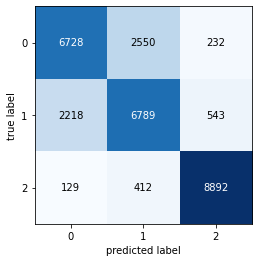

In [59]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_tfidf_best)

plot_confusion_matrix(conf_mat=cm)
plt.show()

### Modelo escolhido

In [60]:
model = LogisticRegression(**study_lr_cv.best_params,
                           random_state=42,
                           n_jobs=-1,
                           solver='newton-cg',
                           multi_class='multinomial')
model.fit(X_train_cv, y_train)
y_pred_cv_best = model.predict(X_test_cv)

print(metrics.classification_report(y_test, y_pred_cv_best))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      9510
           1       0.69      0.70      0.70      9550
           2       0.94      0.93      0.94      9433

    accuracy                           0.78     28493
   macro avg       0.79      0.78      0.79     28493
weighted avg       0.79      0.78      0.78     28493



## Mundo Real

In [61]:
df_rw = pd.read_csv('./Dados/subm/Subm3Classes.csv')
df_rw

,id,tweet_text,tweet_date,query_used
0,1046764676707753987,Apartamento Vila Mariana Praça Monteiro dos Sa...,Mon Oct 01 14:12:01 +0000 2018,:)
1,1047329264943751169,@FalleNCS @BrasilGameShow quero 1x1 de scout. ...,Wed Oct 03 03:35:29 +0000 2018,:)
2,1045443874947313665,mais uma analógica no correio à minha espera :...,Thu Sep 27 22:43:37 +0000 2018,:)
3,1040484298711814144,"Em festa de posse como presidente do STF, Toff...",Fri Sep 14 06:16:02 +0000 2018,folha
4,1045411876887306240,@thethiagor @jubsilva @GSCISA @GrupoMulheRIs A...,Thu Sep 27 20:36:28 +0000 2018,:)
...,...,...,...,...
4995,1049243861732794369,"Não é nada demais , apenas a verdade :) — Oh.....",Mon Oct 08 10:23:25 +0000 2018,:)
4996,1039334757690163201,Veja o que é #FATO ou #FAKE na entrevista de A...,Tue Sep 11 02:08:10 +0000 2018,#fato
4997,1049286902577356801,"@nattvieiira de quem???? queria ver, eu sai po...",Mon Oct 08 13:14:27 +0000 2018,:(
4998,1045349300744671232,ASSASSIN'S CREED ORIGINS: ENFRENTANDO OS IRMÃO...,Thu Sep 27 16:27:49 +0000 2018,:)


In [62]:
df_rw["filtered_words"] = df_rw['tweet_text'].apply(lambda x: preprocessamento_texto(x,sw))

#juntamos as palavras novamente em uma só string

df_rw['join_words'] = df_rw['filtered_words'].apply(lambda x: ' '.join(x))

In [63]:
df_rw

,id,tweet_text,tweet_date,query_used,filtered_words,join_words
0,1046764676707753987,Apartamento Vila Mariana Praça Monteiro dos Sa...,Mon Oct 01 14:12:01 +0000 2018,:),"[apartamento, vila, mariano, praca, monteiro, ...",apartamento vila mariano praca monteiro santo ...
1,1047329264943751169,@FalleNCS @BrasilGameShow quero 1x1 de scout. ...,Wed Oct 03 03:35:29 +0000 2018,:),"[x, scout, dar, muito, balir, cagar]",x scout dar muito balir cagar
2,1045443874947313665,mais uma analógica no correio à minha espera :...,Thu Sep 27 22:43:37 +0000 2018,:),"[analogica, correar, esperar, so, receber, len...",analogica correar esperar so receber lente com...
3,1040484298711814144,"Em festa de posse como presidente do STF, Toff...",Fri Sep 14 06:16:02 +0000 2018,folha,"[festa, posse, presidente, stf, toffoli, canta...",festa posse presidente stf toffoli cantar legi...
4,1045411876887306240,@thethiagor @jubsilva @GSCISA @GrupoMulheRIs A...,Thu Sep 27 20:36:28 +0000 2018,:),"[flavia, tuiter, tambem]",flavia tuiter tambem
...,...,...,...,...,...,...
4995,1049243861732794369,"Não é nada demais , apenas a verdade :) — Oh.....",Mon Oct 08 10:23:25 +0000 2018,:),"[nao, verdade, oh, pronto, obrigadaaaaa]",nao verdade oh pronto obrigadaaaaa
4996,1039334757690163201,Veja o que é #FATO ou #FAKE na entrevista de A...,Tue Sep 11 02:08:10 +0000 2018,#fato,"[fato, fake, entrevisto, anthony, garoto, rjtv]",fato fake entrevisto anthony garoto rjtv
4997,1049286902577356801,"@nattvieiira de quem???? queria ver, eu sai po...",Mon Oct 08 13:14:27 +0000 2018,:(,"[querer, sair, causar, luca]",querer sair causar luca
4998,1045349300744671232,ASSASSIN'S CREED ORIGINS: ENFRENTANDO OS IRMÃO...,Thu Sep 27 16:27:49 +0000 2018,:),"[assassins, creed, origins, enfrentar, irmaos,...",assassins creed origins enfrentar irmaos ze ru...


In [64]:
X_rw = df_rw['join_words']


In [65]:

X_test_rw = cv.transform(X_rw)

In [66]:
model = LogisticRegression(**study_lr_cv.best_params,
                           random_state=42,
                           n_jobs=-1,
                           solver='newton-cg',
                           multi_class='multinomial')
model.fit(X_train_cv, y_train)
y_pred_rw = model.predict(X_test_rw)


In [67]:
#Gerando o arquivo csv com as predições
pd.DataFrame(index=df_rw['id'],data={'sentiment_predict':y_pred_rw}).to_csv('predictions.csv')